notebook中实现了以下内容

1. 详细介绍了周志华老师提出的“深度森林”项目。[B站讲解](https://www.bilibili.com/video/BV1364y1q71s?p=1)

2. 纯python重现了深度森林

3. 用纯python实现随机森林以及SBRANA教授上课所讲的时间序列算法并结合多种机器学习方法预测“海尔智家”（股票代码600690）以及其它31种不同金融资产2021年6月1日到30日之间的价格

4. 详细介绍了郭亮教授提出的BDSCV交叉验证方法。[B站讲解](https://www.bilibili.com/video/BV1364y1q71s?p=2)

5. 用多种统计检验方法比较了深度森林，随机森林以及其它使用的算法

# 问题一 深度森林原理

## 研究背景

### 引言
深度森林(Deep Forest)是周志华教授和冯霁博士在2017年2月28日发表的论文《Deep Forest: Towards An Alternative to Deep Neural Networks》中提出的一种新的可以与深度神经网络相媲美的基于树的模型。Deep Forest的另一种说法为gcForest，因为它的结构可以理解为：multi-Grained Cascade forest(多粒度级联森林)。目前的深度学习模型大多建立在神经网络的基础上，即多层参数化可微非线性模块，可以通过反向传播进行训练。在论文中，两位学者探讨了基于不可微模块建立深层模型的可能性。他们认为，深层神经网络的成功在很大程度上归功于三个特征，即逐层处理、模型特征转换和足够的模型复杂性。在此基础上，他们提出gcForest方法，该方法能够生成同时具有这三个特征的深度森林。这是一种决策树集成方法，与传统深度神经网络相比，具有更少的超参数，并且其模型复杂性可以通过一种与数据相关的方式自动确定。实验表明，此方法在超参数设置方面有很高的鲁棒性，因此在大多数情况下，即使面对不同领域的不同数据，也能够在相同的默认设置下表现出优异的性能。此研究打开了基于不可微模块的深度学习之门，展示了不使用反向传播构建深度模型的可能性。

### 研究出发点
虽然深度神经网络功能强大，但它也有许多不足之处。第一，DNN的超参数过多，学习性能严重依赖于超参数的调整。由于有太多的干扰因素和几乎无限的构型组合，得到性能优异的DNN训练模型变得十分棘手，DNN的理论分析也变得困难。第二，DNN的训练需要大量的训练数据。因此，DNN很难应用于只有小规模训练数据的任务，有时甚至无法完成中等规模训练数据任务。即使在大数据时代，由于标记成本高，许多实际任务仍然缺乏足够数量的标记数据，导致DNN在这些任务中的性能较差。第三，神经网络是一种黑箱模型，其决策过程难以理解，学习行为很难进行理论分析。第四，深度神经网络的结构是在模型训练前确定，模型的复杂性也因此提前确定。如果能够以与数据相关的方式自动确定模型复杂度，模型的性能会更好。尽管DNN已经得到了很好的发展，但是DNN的性能仍然存在不足。
为了解决复杂的学习任务，学习模型需要深入研究。当前的深度模型总是建立在神经网络的基础上。如上所述，有充分的理由来探索非神经网络风格的深层模型，考虑深度学习是否可以与其他模块一起实现。特别是考虑到神经网络是多层参数化可微非线性模块，但是世界上并不是所有的属性都是可微的或者最好建模为可微的。因此该研究试图解决这个基本问题：深度学习是否可以通过不可微分的模块实现？
事实上，机器学习社区已经开发了许多学习模块，而其中许多是不可微的。理解是否有可能基于不可微模块构建深度模型，将有助于揭示这些模块是否可以在深度学习中被利用的问题。

### DNN的启发
普遍认为，表征学习能力对深度神经网络的成功至关重要。在DNN中表征学习的关键在于逐层处理。下图提供了一个示例，当层从底部向上时，更高抽象级别的特征出现。

![](https://ai-studio-static-online.cdn.bcebos.com/fc4a5a294c31453fa9b75de3f09df8884f8e8cff751f453ca7ad9909a0074c00)

目前，存在很多同样进行逐层处理的其他学习模型，例如决策树和强化学习机器，但是不如DNN那么成功。其中最重要的区别因素是，与上图所示生成新特征的DNN不同，决策树和强化学习机器总是在原始特征表示上运作，而不会在学习过程中创建新特征，换句话说，没有模型内特征的转换。此外，与具有任意高模型复杂度的DNN不同，决策树和Boosting机器的模型复杂度有限。尽管模型复杂性本身并不能解释DNN的成功，但是它仍然很重要，因为探索大型数据集需要极大的模型容量。

### 集成学习的启发
集成学习是一种机器学习范式，在该范式中，多个学习者（例如分类器）被训练并组合用于一项任务。众所周知，与单个学习者相比，集成学习者通常可以获得更好的泛化性能。要构建一个好的整体，个体学习者应该准确多样。仅结合准确的学习者往往不如结合一些准确的学习者和一些相对较弱的学习者，因为互补性比纯粹的准确度更重要。在实践中，多样性增强的基本策略是在训练过程中基于一些启发式注入随机性。大致来说，有四大类机制。第一种是数据样本操作，它通过生成不同的数据样本来训练个体学习者。第二种是输入特征操作，它通过生成不同的特征子空间来训练个体学习者。第三种是学习参数操作，它通过使用基础学习算法的不同参数设置来生成不同的个体学习者。第四种是输出表征操纵，它通过使用不同的输出表征来产生不同的个体学习者。深度森林模型可以被视为一种决策树集成方法，其利用几乎所有类别的机制来增强多样性。

## 深度森林（gcForest）原理

### 级联森林结构
深度神经网络中的表征学习主要依赖于原始特征的逐层处理。受此启发，gcForest采用了一种级联结构。如下图所示，其中每一级都是决策树林的集合，每一级接收前一级处理的特征信息，并将其处理结果输出到下一级。

![](https://ai-studio-static-online.cdn.bcebos.com/6ffb29c7c61f4c01a7cb218aeeb737790dd7ba52849446da843e56857eda0084)


为了提高多样性，每一级都包括不同类型的森林，因为多样性对于整体构建至关重要。为了简单起见，上图假设级联的每个层级由两个随机森林（random forest黑色）和两个完全随机树森林（completely-random tree forest蓝色）组成，并假设有三个可预测的类别；因此，每个随机森林将输出一个三维类向量，然后将其连接起来以重新表示原始输入。每个完全随机森林由500棵决策树组成，每棵决策树是通过在每个节点随机选取分类特征得到的，并且在这个过程中让树完全生长，也就是说树的每个叶节点只包含一类样例。类似的，每个普通随机森林由500棵决策树构成，每棵树是通过随机选取√k个候选特征（k表示输入特征维度，即特征数），然后选择gini系数最大特征进行划分得到的。
举个例子，每个森林将计算相关样本在每棵随机树上所落入的叶节点上不同类别的百分比，然后对森林中所有随机树的结果求平均值，生成该样本类别分布的估计值。每个随机森林所估计的样本类别分布形成一个类向量，将其与原始特征向量串联，以输入到下一层级联。假设有三个类别，那么四个随机森林中将分别产生一个三维类向量，下一层级联将接收12（=3×4）个增强特征。如下图所示，其中红色线条显示相关样本到叶节点的路径。

![](https://ai-studio-static-online.cdn.bcebos.com/fa181c78791645d1ba1bb194f768e72a06998c2f34a9499b9d4b565dc3c13493)

为了减少过拟合的可能性，每个森林所产生的类向量(class vector)是通过k-折叠交叉验证生成的。具体来说，每个样本都将作为训练数据使用k-1次，如此得到 k-1个类向量，然后对其进行平均以生成最终类向量，作为下一级级联的增强特征。在生成新一层级联后，将在一个测试集上对模型的性能进行估计，如果相较上次无明显提高，训练过程就会停止。也就是说，模型中级联的数量是自动确定的。因此gcForest可以根据数据规模动态的调整模型复杂度。

### 多粒度扫描

深度神经网络在处理特征关系方面非常强大，例如，在原始像素之间的空间关系非常关键的情况下，卷积神经网络对图像数据非常有效；在序列关系至关重要的序列数据上，递归神经网络非常有效。受此启发，深度森林模型在级联森林中引入多粒度扫描过程。

![](https://ai-studio-static-online.cdn.bcebos.com/aba415f79afd4f89b7e991b12b6d552e2c75baf11a1f4f8c8c64d35e8436fdbf)

如上图所示，我们使用滑动窗口扫描原始特征。如果假设原始特征数为400，窗口宽度为100，那么滑动一次窗口将生成一个100维特征向量，总共将生成301个特征向量。如果原始特征是有空间关系的，比如20x20的400个照片像素点，那么10x10的窗口会产生共121个特征向量。从正/负训练样本中提取的所有特征向量被视为正/负实例，将用于生成类向量，如2.1节所述：从相同大小的窗口中提取的实例将用于训练两类随机森林，然后生成类向量并将其作为变换后的特征进行连接。如上图所示，假设有3个类，使用100维窗口，那么每个森林生成301个三维类向量，得到与原始400维特征向量相对应的1806维变换特征向量。
上图仅显示了一种尺寸的滑动窗口。实际上，通过使用多种大小的滑动窗口，将生成不同粒度的特征向量。

### 总体程序

![](https://ai-studio-static-online.cdn.bcebos.com/84ab233d00584a59b796dac8846dfaca502d42f819dc4376b34b5cf1a144be5f)

上图展示了深度森林模型总体过程，假设原始输入为400个原始特征，并且将三个窗口大小用于多粒度扫描。对于m个训练样例，大小为100个特征的窗口将生成一个包含301×m 个100维训练样例的数据集，此数据将用于训练两类随机森林，每个森林包含500棵树。如果有三类待预测，将获得2.1节所述的1806维特征向量。转换后的训练集将用于训练第一层级联森林。
类似地，大小为200个和300个特征的滑动窗口将分别从原始特征向量生成1206维和606维特征向量，转换后的特征向量与前一层生成的类向量相连接，分别用于训练级联森林的第二层和第三层，重复该程序，直到验证性能趋于收敛。换句话说，最终的模型实际上是一个级联，其中每个级联由多个层级组成，每个层级对应一个扫描粒度。例如，上图中第一个级联由层级1A到层级1C组成。对于困难的任务，如果计算资源允许，用户可以尝试更多的粒度。
对于一个满足上述假设的样例，深度森林模型将通过多粒度扫描过程获得相应的转换特征向量，然后通过级联森林层层分类直到最后一级级联。最终在最后一级级联聚合四个三维类向量，获取到聚合值最大的类别，即为预测结果。

## 实验与性能评估

### 模型参数配置
在所有实验中，gcForest都使用相同的级联结构：如第2.1节所述，每个层级由2个完全随机森林和2个随机森林组成，每个森林包含500棵树。三重交叉验证用于类向量生成。级联级别的数量将自动确定。具体来说，我们将训练集分为两部分，即增长集和估计集，我们使用增长集来增长级联，使用估计集来估计性能；如果增加一个新的级别并不能提高性能，则级联的增长将终止，并获得估计的级别数；然后，在合并生长集和估计集的基础上对级联进行重新训练。对于所有实验，我们将80%的训练数据用于增长集，20%用于估计集。对于多粒度扫描，使用三种窗口大小。对于d维原始特征，我们使用尺寸为d/16、d/8、d/4的特征窗口；如果原始功能具有面板结构（如图像），则功能窗口也具有面板结构。
对于深度神经网络，在验证集上检查各种结构，选择性能最好的结构，然后在训练集上重新训练整个网络，并报告测试精度。

### 实验结果

实验一：图像分类
MNIST数据集包含60000张大小为28×28的图像，用于训练（和验证），10000张图像用于测试。我们将其与LeNet-5（有drop-out和ReLUs）、SVM（有rbf核）和标准随机森林（2000棵树）进行了比较。模型在测试集上的准确度结果表明，gcForest虽然只是使用默认设置，但实现了极具竞争力的性能。
![](https://ai-studio-static-online.cdn.bcebos.com/20da1e90afaf4c9d9177a7a5d1a0542384a1c263acf04fadbb9e9861b570bebb)

实验二：人脸识别
ORL数据集包含来自40个人的400幅灰度面部图像。将其与由2个conv层和32个3×3内核的特征映射组成的CNN进行比较，每个conv层后面都有一个2×2最大池层。一个由128个隐藏单元组成的密集层与卷积层完全连接，最后在末尾附加一个由40个隐藏单元组成的完全连接的soft max层。上述配置是尝试过的CNN配置中性能最好的。我们随机选择每个人5/7/9张图片进行训练，并报告剩余图片的测试性能。这里的KNN方法对所有情况都使用K=3。模型在测试集上的准确度结果表明，gcForest在所有三种情况下都运行良好。

![](https://ai-studio-static-online.cdn.bcebos.com/8786c22aaa214c94ad7757f7f75d72ccc9c412f3bcb04f82b3a5399581d78cfd)

实验三：低维数据
我们在UCI数据集上评估gcForest，特征数量相对较少：LETTER有16个特征和16000/4000个训练/测试样例；ADULT有14个特征和32561/16281个训练/测试样例；YEAST只有8个特征和1038/446个训练/测试样例。CNN由于其结构特点无法处理此类数据。因此，我们将其与MLP进行比较。不幸的是，尽管MLP的配置选项比CNN少，但它们的设置仍然非常棘手，没有办法选择一个MLP结构，它可以在所有数据集上提供良好的性能。因此，我们报告了具有最佳性能的不同MLP结构：对于LETTER，结构为输入-70-50-output；对于ADULT，结构为输入-30-20-output；对于YEAST，结构为输入-50-30-output。相比之下，gcForest使用与之前相同的配置，但考虑到这些小规模数据的特征不具有空间或顺序关系，因此放弃了多粒度扫描。模型在测试集上的准确度结果如下。

![](https://ai-studio-static-online.cdn.bcebos.com/b99ef5f52a8b492584bebcb672a106a7a1ef8a3953894df9bd8c95d2e465a409)

实验四：高维数据
CIF AR-10数据集包含用于培训的10个类的50000张图像和用于测试的10000张图像。每个图像是一个32×32的彩色图像，具有8个灰度级；因此，每个实例都是8192 dim。模型在测试集上的准确度结果如下表所示，其中还包括几个深度神经网络的结果。

![](https://ai-studio-static-online.cdn.bcebos.com/2c277202df2e4c97b897a54eb373157ef4131178ec764ad19c99152c3486ffda)

正如我们在之前所讨论的，目前我们只使用来自每个森林的10维增强特征向量，这样少量的增强特征很容易被原始长特征向量淹没。尽管具有默认设置的gcForest不如最先进的DNN，但它已经是非DNN方法中最好的。

实验五：多粒度扫描的影响   
   为了研究级联森林结构和多粒度扫描的单独贡献，在MNIST、GTZAN和sEMG数据集上比较了多粒度级联森林（gcforest）和级联森林（CascadeForest）。显然，当存在空间或顺序特征关系时，多粒度扫描过程有助于明显提高性能。
![](https://ai-studio-static-online.cdn.bcebos.com/48ff28058642432aa65ea612f409c7c2456b1ea663ab4200bafa76ba396a9f1f)

实验六：级联结构的影响
gcForest的最终模型结构是级联，其中每个级联由多个层级组成，每个层级对应于一个扫描粒度，如2.1所述。还有其他可能的方法利用多个粒度的特征，例如，将所有转化后的特征向量串联在一起，如下图所示。
![](https://ai-studio-static-online.cdn.bcebos.com/6f50da99bdce4a40924c18389257517dfea41344800e496dbc053dd21b0de126)
将两种级联结构进行了比较，结果表明将多个颗粒的特征串联的结构性能不如先前2.1中所述的gcForest结构。尽管如此，可能还有其他方法可以带来更好的结果，我们把它留给未来的探索。
![](https://ai-studio-static-online.cdn.bcebos.com/c3068e8af21d4340b50967849a58faf37ceb409c0283434dae12eacfe9bf8383)

### 总结
通过多粒度级联森林方法（gcForest）来构建深度森林，是一种非神经网络类型的深度模型。这是一个新的决策树集成方法，具有级联结构，能够通过随机森林进行表征学习。它的表征学习能力可以通过多粒度扫描进一步增强，这可能使gcForest具有上下文或结构感知能力。它可以自动确定级联的级别数量，从而可以与数据相关的方式确定模型复杂性，而不是在训练前盲目手动设计，这使得gcForest即使在小规模数据上也能发挥出色，并使用户能够根据可用的计算资源控制训练成本。此外，gcForest的超参数比DNN少得多。更进一步，它的性能对超参数设置具有很高的鲁棒性；实验表明，在大多数情况下，即使在不同领域的不同的数据中，使用默认设置也可以获得优异的性能。





#  问题二  纯python复现深度森林(分类 回归)

## 分类

深度森林可以用于分类问题与回归问题，周志华老师的文章中详细介绍了用于分类问题的深度森林构建方法。下面是复现代码

In [33]:

import numpy as np
from sklearn.model_selection import train_test_split

class CascadeForestClassifier(object):

    def __init__(self, dim=None, n_mgs_tree=30, window=None, stride=1, n_cascade_rf=2, n_cascade_tree=100,n_jobs=1):
        """ 使用级联森林对样本进行分类
        :param dim: int, 样本尺寸
        :param n_mgs_tree: int, 在多粒度扫描阶段使用的随机森林中的树的数量
        :param window: list, 在多粒度扫描阶段使用的滑动窗口的尺寸
        :param stride: int, 滑动窗口的步长
        :param n_cascade_rf: int
                在级联森林阶段使用的随机森林的数量。由于每层级联中的随机森林对应一个完全随机森林，实际生成的森林数量要×2
        :param n_cascade_tree: int
                在级联森林阶段使用的随机森林中的树的数量
        :param n_jobs: int, 随机森林中的参数。运行的线程数
        """
        self.dim=dim
        self.layer_dep=0
        self.n_samples=0
        self.n_cascade_rf=int(n_cascade_rf)
        self.window=window      # 必须是list
        self.stride=stride
        self.n_mgs_tree=int(n_mgs_tree)
        self.n_cascade_tree=int(n_cascade_tree)
        self.scanning_layer_dep=0
        self.n_jobs=n_jobs
        from sklearn.ensemble import RandomForestClassifier

    def fit(self, X, y):
        """ 训练深度森林
        :param X: array, 训练数据
        :param y: array, 标签数据
        """
        scanned_X = self.scanning(X, y)
        self.cascade_forest(scanned_X, y)

    def class_prob(self, X):
        """ 计算样本为某类的概率
        :param X: array, 训练数据
        :return: array, 样本分布密度
        """
        scanned_X = self.scanning(X)
        probability = self.cascade_forest(scanned_X)
        # print(probability)
        res = np.mean(probability, axis=0)

        return res

    def predict(self, X):
        """ 根据样本概率函数预测样本标签
        :param X: array, 训练数据
        :return: array, 样本对应的标签
        """
        probability = self.class_prob(X=X)
        predictions = np.argmax(probability, axis=1)

        return predictions

    def scanning(self, X, y=None):
        """ 多粒度扫描过程
        :param X: array, 训练数据
        :param y: array, 标签数据
        :return: array, 多粒度扫描输出
        """
        self.n_samples=np.shape(X)[0]
        dim=self.dim

        if isinstance(dim, int):
            dim = [1,dim]
        if not getattr(self, 'window'):
            self.window=[dim[1]]

        probability = []
        for s in self.window:
            tmp = self.scanning_layer(X=X, window=s, dim=dim, y=y)
            probability.append(tmp)

        return np.concatenate(probability, axis=1)

    def scanning_layer(self, X, window, dim, y=None):
        """ 在输入数据上进行滑动窗口取样并将得到的数据使用随机森林进行训练
        :param X: array, 训练数据
        :param window: int, 窗口尺寸
        :param dim: array, 样本尺寸
        :param y: array, 标签数据，如果不为空则进行训练
        :return: array, 个输入样本对应的标签的可能性
        """
        n_tree=self.n_mgs_tree
        stride=self.stride

        # 判断输入为矩阵还是序列
        if dim[0] == 1:
            sliced_X, sliced_y = self.slicing_window_arr(X=X, window=window, dim=dim, y=y, stride=stride)
        else:
            sliced_X, sliced_y = self.slicing_window_mat(X=X, window=window, dim=dim, y=y, stride=stride)

        if y is not None:
            self.scanning_layer_dep += 1
            print('Training MGS layer = {}'.format(self.scanning_layer_dep))
            # standard random forest
            srf = RandomForestClassifier(n_estimators=n_tree, max_features='auto', oob_score=True, n_jobs=self.n_jobs)
            srf.fit(sliced_X, sliced_y)
            setattr(self, 'mgs_srf_{}'.format(window), srf)
            srf_out = srf.oob_decision_function_
            # complete random forest
            crf = RandomForestClassifier(n_estimators=n_tree, max_features=1, oob_score=True, n_jobs=self.n_jobs)
            crf.fit(sliced_X, sliced_y)
            setattr(self, 'mgs_crf_{}'.format(window), crf)
            crf_out = crf.oob_decision_function_
        elif y is None:
            if hasattr(self, 'mgs_srf_{}'.format(window)):
                srf = getattr(self, 'mgs_srf_{}'.format(window))
                crf = getattr(self, 'mgs_crf_{}'.format(window))
                srf_out = srf.predict_proba(sliced_X)
                crf_out = crf.predict_proba(sliced_X)

        res = np.c_[srf_out, crf_out]
        return res.reshape([self.n_samples, -1])

    def slicing_window_mat(self, X, window, dim, y=None, stride=1):
        """ 多维滑动窗口
        :param X: array, 训练数据
        :param window: int, 窗口尺寸
        :param dim: array, 样本尺寸
        :param y: array, 标签数据
        :param stride: int, 长
        :return: array, array: 分割以后的数据和它的标签
        """
        xx = int(np.floor_divide((dim[1] - window),stride)) + 1
        yy = int(np.floor_divide((dim[0] - window),stride)) + 1

        tmp = np.arange(0, window)
        for i in range(window):
            if i == 0:
                index_t = np.ravel(tmp+dim[1]*i)
            else:
                index_t = np.concatenate([index_t, np.ravel(tmp+dim[1]*i)])

        arr_x = np.arange(0, stride * xx, stride)
        arr_y = np.arange(0, stride * yy, stride)
        for x_iter in arr_x:
            for y_iter in arr_y:
                if x_iter == 0 and y_iter == 0:
                    index = [index_t + x_iter + dim[1] * y_iter]
                else:
                    index = np.append(index, [index_t + x_iter + dim[1] * y_iter],axis=0)

        sliced_X = np.take(X, index, axis=1).reshape(-1, window**2)
        sliced_y = None
        
        if y is not None:
            sliced_y = np.repeat(y, xx * yy)

        return sliced_X, sliced_y

    def slicing_window_arr(self, X, window, dim, y=None, stride=1):
        """ 使用滑动窗口拆分序列数据
        :param X: array, 训练数据
        :param window: int, 窗口尺寸
        :param dim: array, 样本尺寸
        :param y: array, 标签数据
        :param stride: int, 长
        :return: array, array: 分割以后的数据和它的标签
        """
        xx = int(np.floor_divide((dim[1] - window),stride)) + 1

        index_t = np.arange(dim[0]*dim[1])
        arr_x = np.arange(0, stride * xx, stride)
        for i in arr_x:
            if i == 0:
                index = [index_t[i:i+window]]
            else:
                index = np.append(index,[index_t[i:i+window]],axis=0)

        sliced_X = np.take(X, index, axis=1)
        sliced_X = sliced_X.reshape(-1, window)

        sliced_y = None
        if y is not None:
            sliced_y = np.repeat(y, xx)

        return sliced_X, sliced_y

    def cascade_forest(self, X, y=None):
        """ 级联森林部分
        :param X: array, 训练数据
        :param y: array, 标签数据
        :return: array, 基于训练数据预测出的标签数据
        """
        if y is not None:
            self.layer_dep=0
            X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

            self.layer_dep += 1
            tmp_pred = self.forest_layer(X_train, y_train)
            tmp_acc = self.forest_evaluation(X_test, y_test)
            feature = self.get_feature(X_train, tmp_pred)

            self.layer_dep += 1
            layer_pred = self.forest_layer(feature, y_train)
            layer_acc = self.forest_evaluation(X_test, y_test)

            while layer_acc > tmp_acc:
                self.layer_dep += 1
                tmp_acc = layer_acc
                tmp_pred = layer_pred
                feature = self.get_feature(X_train, tmp_pred)
                layer_pred = self.forest_layer(feature, y_train)
                layer_acc = self.forest_evaluation(X_test, y_test)

            # 如果准确率下降，那么删去最下面的一层级联
            if layer_acc < tmp_acc :
                n_cascade_rf = self.n_cascade_rf
                for i in range(n_cascade_rf):
                    delattr(self, 'cascade_srf_{}_{}'.format(self.layer_dep, i))
                    delattr(self, 'cascade_crf_{}_{}'.format(self.layer_dep, i))
                self.layer_dep -= 1
                
        if y is None:
            dep = 1
            tmp_pred = self.forest_layer(X, layer=dep)
            while dep < self.layer_dep:
                dep += 1
                feature = self.get_feature(X, tmp_pred)
                tmp_pred = self.forest_layer(feature, layer=dep)

        return tmp_pred

    def forest_layer(self, X, y=None, layer=0):
        """ 级联森林中的层级
        :param X: array, 训练数据
        :param y: array, 标签数据
        :param layer: int, 层级编号
        :return: array, 对训练数据的预测
        """
        n_jobs = self.n_jobs
        n_tree = self.n_cascade_tree
        n_cascade_rf = self.n_cascade_rf
        
        srf = RandomForestClassifier(n_estimators=n_tree, max_features='auto', oob_score=True, n_jobs=n_jobs)
        crf = RandomForestClassifier(n_estimators=n_tree, max_features=1, oob_score=True, n_jobs=n_jobs)

        pred = []
        if y is None:
            for i in range(n_cascade_rf):
                srf = getattr(self, 'cascade_srf_{}_{}'.format(layer, i))
                pred.append(srf.predict_proba(X))
                crf = getattr(self, 'cascade_crf_{}_{}'.format(layer, i))
                pred.append(crf.predict_proba(X))
        if y is not None:
            print('Fitting cascade layer={}'.format(self.layer_dep))
            for i in range(n_cascade_rf):
                srf.fit(X, y)
                pred.append(srf.oob_decision_function_)
                setattr(self, 'cascade_srf_{}_{}'.format(self.layer_dep, i), srf)
                crf.fit(X, y)
                pred.append(crf.oob_decision_function_)
                setattr(self, 'cascade_crf_{}_{}'.format(self.layer_dep, i), crf)

        return pred

    def calc_accuracy(self, test, prediction):
        """ 计算预测的准确率
        :param test: 测试数据
        :param prediction: 预测数据
        :return: 准确率
        """
        acc = 0
        for i in range(len(test)):
            if test[i] == prediction[i]:
                acc += 1

        acc = acc / len(prediction)
        return acc

    def forest_evaluation(self, X_test, y_test):
        """ 计算级联森林准确率
        :param X_test: array, 测试数据
        :param y_test: array, 测试标签
        :return: float, 准确率
        """
        prediction = np.argmax(np.mean(self.cascade_forest(X_test), axis=0), axis=1)
        acc = self.calc_accuracy(y_test, prediction)
        print('Val Acc = {}'.format(acc))

        return acc

    def get_feature(self, X, pred):
        """ 把原有特征与每层生成的特征连接起来
        :param X: array, 训练数据
        :param pred: list, 训练数据的标签分布密度
        :return: np.array, 级联森林层级输出
        """
        # print("pred",np.shape(pred))
        swap_pred = np.swapaxes(pred, 0, 1)
        # print("swap_pred",np.shape(swap_pred))
        feat=np.take(pred,range(len(pred)),axis=1)
        # print("feat",np.shape(feat))
        add_feat = swap_pred.reshape([np.shape(X)[0], -1])
        # print("add_feat",np.shape(add_feat))
        feature = np.concatenate([add_feat, X], axis=1)

        return feature

### 测试

我们对上面实现的深度森林分类器进行检验。使用的数据集为手写数字识别以及iris样本分类数据集。

In [34]:
from sklearn.datasets import load_digits,load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# 测试手写数字识别数据集
# 深度森林
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
model = CascadeForestClassifier(dim=[8,8], window=[4,6])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = model.calc_accuracy(y_test, y_pred) * 100
print("\n深度森林手写数字识别准确率: {:.3f} %".format(acc))

# 随机森林
model = RandomForestClassifier(oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test,y_pred) * 100
print("\n随机森林手写数字识别准确率: {:.3f} %".format(acc))

# 测试iris样本分类数据集
# 深度森林
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
model = CascadeForestClassifier(dim=4, window=[2])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("\n深度森林iris样本分类准确率: {:.3f} %".format(acc))

# 随机森林
model = RandomForestClassifier(oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test,y_pred) * 100
print("\n随机森林iris样本分类准确率: {:.3f} %".format(acc))

Training MGS layer = 1
Training MGS layer = 2
Fitting cascade layer=1
Val Acc = 0.9851632047477745
Fitting cascade layer=2
Val Acc = 0.9881305637982196
Fitting cascade layer=3
Val Acc = 0.9881305637982196

深度森林手写数字识别准确率: 98.444 %

随机森林手写数字识别准确率: 97.778 %
Training MGS layer = 1
Fitting cascade layer=1
Val Acc = 1.0
Fitting cascade layer=2
Val Acc = 1.0

深度森林iris样本分类准确率: 97.368 %

随机森林iris样本分类准确率: 97.368 %


从对比的结果来看，深度森林和随机森林的分类准确率都非常高，他们的结果没有太大差异，这可能是由于使用的数据集比较简单的原因所致。

## 回归

下面是深度森林回归的python代码

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split

class CascadeForestRegressor(object):

    def __init__(self, dim=None, n_mgs_tree=30, window=None, stride=1, n_cascade_rf=2, n_cascade_tree=100,n_jobs=1):
        """ 使用级联森林获取样本回归数据
        :param dim: int, 样本尺寸
        :param n_mgs_tree: int, 在多粒度扫描阶段使用的随机森林中的树的数量
        :param window: list, 在多粒度扫描阶段使用的滑动窗口的尺寸
        :param stride: int, 滑动窗口的步长
        :param n_cascade_rf: int
                在级联森林阶段使用的随机森林的数量。由于每层级联中的随机森林对应一个完全随机森林，实际生成的森林数量要×2
        :param n_cascade_tree: int
                在级联森林阶段使用的随机森林中的树的数量
        :param n_jobs: int, 随机森林中的参数。运行的线程数
        """
        self.dim=dim
        self.layer_dep=0
        self.n_samples=0
        self.n_cascade_rf=int(n_cascade_rf)
        self.window=window      # 必须是list
        self.stride=stride
        self.n_mgs_tree=int(n_mgs_tree)
        self.n_cascade_tree=int(n_cascade_tree)
        self.scanning_layer_dep=0
        self.n_jobs=n_jobs
        from sklearn.ensemble import RandomForestRegressor

    def fit(self, X, y):
        """ 训练深度森林
        :param X: array, 训练数据
        :param y: array, 回归数据
        """
        scanned_X = self.scanning(X, y)
        self.cascade_forest(scanned_X, y)

    def class_prob(self, X):
        """ 计算样本对应的回归数据
        :param X: array, 训练数据
        :return: array, 样本分布密度
        """
        scanned_X = self.scanning(X)
        probability = self.cascade_forest(scanned_X)
        # print(probability)
        res = np.mean(probability, axis=0)

        return res

    def predict(self, X):
        """ 根据样本可能回归数据预测样本回归数据
        :param X: array, 训练数据
        :return: array, 样本回归数据
        """
        predictions = self.class_prob(X=X)
        # print(np.shape(predictions))

        return predictions

    def scanning(self, X, y=None):
        """ 多粒度扫描过程
        :param X: array, 训练数据
        :param y: array, 回归数据
        :return: array, 多粒度扫描输出
        """
        self.n_samples=np.shape(X)[0]
        dim=self.dim

        if isinstance(dim, int):
            dim = [1,dim]
        if not getattr(self, 'window'):
            self.window=[dim[1]]

        probability = []
        for s in self.window:
            tmp = self.scanning_layer(X=X, window=s, dim=dim, y=y)
            probability.append(tmp)

        return np.concatenate(probability, axis=1)

    def scanning_layer(self, X, window, dim, y=None):
        """ 在输入数据上进行滑动窗口取样并将得到的数据使用随机森林进行训练
        :param X: array, 训练数据
        :param window: int, 窗口尺寸
        :param dim: array, 样本尺寸
        :param y: array, 回归数据，如果不为空则进行训练
        :return: array, 输入样本回归数据
        """
        n_tree=self.n_mgs_tree
        stride=self.stride

        # 判断输入为矩阵还是序列
        if dim[0] == 1:
            sliced_X, sliced_y = self.slicing_window_arr(X=X, window=window, dim=dim, y=y, stride=stride)
        else:
            sliced_X, sliced_y = self.slicing_window_mat(X=X, window=window, dim=dim, y=y, stride=stride)

        if y is not None:
            self.scanning_layer_dep += 1
            print('Training MGS layer = {}'.format(self.scanning_layer_dep))
            # standard random forest
            srf = RandomForestRegressor(n_estimators=n_tree, max_features='auto', oob_score=True, n_jobs=self.n_jobs)
            srf.fit(sliced_X, sliced_y)
            setattr(self, 'mgs_srf_{}'.format(window), srf)
            srf_out = srf.oob_prediction_
            # complete random forest
            crf = RandomForestRegressor(n_estimators=n_tree, max_features=1, oob_score=True, n_jobs=self.n_jobs)
            crf.fit(sliced_X, sliced_y)
            setattr(self, 'mgs_crf_{}'.format(window), crf)
            crf_out = crf.oob_prediction_
        elif y is None:
            if hasattr(self, 'mgs_srf_{}'.format(window)):
                srf = getattr(self, 'mgs_srf_{}'.format(window))
                crf = getattr(self, 'mgs_crf_{}'.format(window))
                srf_out = srf.predict(sliced_X)
                crf_out = crf.predict(sliced_X)

        res = np.c_[srf_out, crf_out]
        return res.reshape([self.n_samples, -1])

    def slicing_window_mat(self, X, window, dim, y=None, stride=1):
        """ 多维滑动窗口
        :param X: array, 训练数据
        :param window: int, 窗口尺寸
        :param dim: array, 样本尺寸
        :param y: array, 回归数据
        :param stride: int, 长
        :return: array, array: 分割以后的数据和它的回归数据
        """
        xx = int(np.floor_divide((dim[1] - window),stride)) + 1
        yy = int(np.floor_divide((dim[0] - window),stride)) + 1

        tmp = np.arange(0, window)
        for i in range(window):
            if i == 0:
                index_t = np.ravel(tmp+dim[1]*i)
            else:
                index_t = np.concatenate([index_t, np.ravel(tmp+dim[1]*i)])

        arr_x = np.arange(0, stride * xx, stride)
        arr_y = np.arange(0, stride * yy, stride)
        for x_iter in arr_x:
            for y_iter in arr_y:
                if x_iter == 0 and y_iter == 0:
                    index = [index_t + x_iter + dim[1] * y_iter]
                else:
                    index = np.append(index, [index_t + x_iter + dim[1] * y_iter],axis=0)

        sliced_X = np.take(X, index, axis=1).reshape(-1, window**2)
        sliced_y = None
        
        if y is not None:
            sliced_y = np.repeat(y, xx * yy)

        return sliced_X, sliced_y

    def slicing_window_arr(self, X, window, dim, y=None, stride=1):
        """ 使用滑动窗口拆分序列数据
        :param X: array, 训练数据
        :param window: int, 窗口尺寸
        :param dim: array, 样本尺寸
        :param y: array, 回归数据
        :param stride: int, 长
        :return: array, array: 分割以后的数据和它的回归数据
        """
        xx = int(np.floor_divide((dim[1] - window),stride)) + 1

        index_t = np.arange(dim[0]*dim[1])
        arr_x = np.arange(0, stride * xx, stride)
        for i in arr_x:
            if i == 0:
                index = [index_t[i:i+window]]
            else:
                index = np.append(index,[index_t[i:i+window]],axis=0)

        sliced_X = np.take(X, index, axis=1)
        sliced_X = sliced_X.reshape(-1, window)

        sliced_y = None
        if y is not None:
            sliced_y = np.repeat(y, xx)

        return sliced_X, sliced_y

    def cascade_forest(self, X, y=None):
        """ 级联森林部分
        :param X: array, 训练数据
        :param y: array, 回归数据
        :return: array, 基于训练数据预测出的回归数据
        """
        if y is not None:
            self.layer_dep=0
            X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

            self.layer_dep += 1
            tmp_pred = self.forest_layer(X_train, y_train)
            tmp_acc = self.mean_squared_error(X_test, y_test)
            feature = self.get_feature(X_train, tmp_pred)

            self.layer_dep += 1
            layer_pred = self.forest_layer(feature, y_train)
            layer_acc = self.mean_squared_error(X_test, y_test)

            print("layer_acc",layer_acc)
            print("tmp_acc",tmp_acc)
            while self.layer_dep <= 10:
                self.layer_dep += 1
                tmp_acc = layer_acc
                tmp_pred = layer_pred
                feature = self.get_feature(X_train, tmp_pred)
                layer_pred = self.forest_layer(feature, y_train)
                layer_acc = self.mean_squared_error(X_test, y_test)

            # 如果准确率下降，那么删去最下面的一层级联
            if layer_acc < tmp_acc :
                n_cascade_rf = self.n_cascade_rf
                for i in range(n_cascade_rf):
                    delattr(self, 'cascade_srf_{}_{}'.format(self.layer_dep, i))
                    delattr(self, 'cascade_crf_{}_{}'.format(self.layer_dep, i))
                self.layer_dep -= 1
                
        if y is None:
            dep = 1
            tmp_pred = self.forest_layer(X, layer=dep)
            while dep < self.layer_dep:
                dep += 1
                feature = self.get_feature(X, tmp_pred)
                tmp_pred = self.forest_layer(feature, layer=dep)

        return tmp_pred

    def forest_layer(self, X, y=None, layer=0):
        """ 级联森林中的层级
        :param X: array, 训练数据
        :param y: array, 回归数据
        :param layer: int, 层级编号
        :return: array, 对训练数据的预测
        """
        n_jobs = self.n_jobs
        n_tree = self.n_cascade_tree
        n_cascade_rf = self.n_cascade_rf
        
        srf = RandomForestRegressor(n_estimators=n_tree, max_features='auto', oob_score=True, n_jobs=n_jobs)
        crf = RandomForestRegressor(n_estimators=n_tree, max_features=1, oob_score=True, n_jobs=n_jobs)

        pred = []
        if y is None:
            for i in range(n_cascade_rf):
                srf = getattr(self, 'cascade_srf_{}_{}'.format(layer, i))
                pred.append(srf.predict(X))
                crf = getattr(self, 'cascade_crf_{}_{}'.format(layer, i))
                pred.append(crf.predict(X))
        if y is not None:
            print('Fitting cascade layer={}'.format(self.layer_dep))
            for i in range(n_cascade_rf):
                srf.fit(X, y)
                pred.append(srf.oob_prediction_)
                setattr(self, 'cascade_srf_{}_{}'.format(self.layer_dep, i), srf)
                crf.fit(X, y)
                pred.append(crf.oob_prediction_)
                setattr(self, 'cascade_crf_{}_{}'.format(self.layer_dep, i), crf)

        return pred

    def mean_squared_error(self,X_test, y_test):
        """
        计算均方误差
        :param X_test: 测试数据
        :param y_test: 回归数据
        :return: 均方误差
        """
        # print(np.shape(self.cascade_forest(X_test)))
        # print(np.shape(y_test))
        # print(np.mean(self.cascade_forest(X_test),axis=0))
        pred = np.mean(self.cascade_forest(X_test), axis=0)
        # print(np.shape(pred))
        # print(np.shape(y_test))
        mse = mean_squared_error(pred,y_test)
        print(mse)
        return mse

    def get_feature(self, X, pred):
        """ 把原有特征与每层生成的特征连接起来
        :param X: array, 训练数据
        :param pred: list, 训练数据的回归数据
        :return: np.array, 级联森林层级输出
        """
        # print("pred",np.shape(pred))
        swap_pred = np.swapaxes(pred, 0, 1)
        # print("swap_pred",np.shape(swap_pred))
        feat=np.take(pred,range(len(pred)),axis=1)
        # print("feat",np.shape(feat))
        add_feat = swap_pred.reshape([np.shape(X)[0], -1])
        # print("add_feat",np.shape(add_feat))
        feature = np.concatenate([add_feat, X], axis=1)

        return feature

## 测试

使用深度森林预测boston房价

In [11]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# boston房价数据集
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# 随机森林
model = RandomForestRegressor(oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\nTesting MSE: {:.3f}".format(mse))

# 深度森林
model = CascadeForestRegressor(dim=10, window=[2])
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\nTesting MSE: {:.3f}".format(mse))


Testing MSE: 8.620
Training MGS layer = 1
Fitting cascade layer=1
15.124071497368435
Fitting cascade layer=2
14.495589713157901
layer_acc 14.495589713157901
tmp_acc 15.124071497368435
Fitting cascade layer=3
14.141290273684229
Fitting cascade layer=4
14.118992844736857
Fitting cascade layer=5
14.319786550000002
Fitting cascade layer=6
14.068874821052647
Fitting cascade layer=7
15.038058357894752
Fitting cascade layer=8
14.414357789473693
Fitting cascade layer=9
13.563734142105272
Fitting cascade layer=10
13.868503742105272
Fitting cascade layer=11
14.724983602631587

Testing MSE: 18.590


# 问题三  海尔智家股票预测
## ARIMA
数据处理

In [36]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy as stats
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA

In [37]:
import matplotlib
print(matplotlib.matplotlib_fname())

E:\Anaconda\lib\site-packages\matplotlib\mpl-data\matplotlibrc


交易日期
2020-07-23    17.61
2020-07-24    16.57
2020-07-27    16.26
2020-07-28    16.36
2020-07-29    18.00
              ...  
2021-05-25    30.07
2021-05-26    31.17
2021-05-27    31.18
2021-05-28    30.68
2021-05-31    30.17
Name: 收盘价, Length: 205, dtype: float64


Text(0, 0.5, '收盘价')

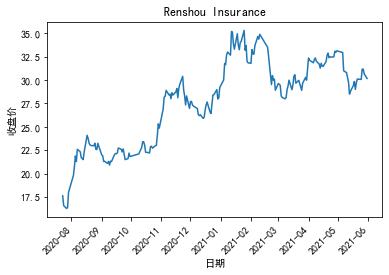

In [38]:
df=pd.read_csv('海尔智家.csv',index_col='交易日期')
#读取数据
df.head()
df.index = pd.to_datetime(df.index)   #进行索引
df.index
ts=df['收盘价']  #时间序列的变量为"open"，并赋值给"ts "
ts=ts['2021-5-31' : '2020-7-23']
ts=ts.reindex(ts.index[::-1])
print(ts)  #读出open的前5个数据
plt.rcParams['font.sans-serif'] = ['simhei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
ts.plot()
plt.title("Renshou Insurance")  #添加图标题
plt.xticks(rotation=45)    #横坐标旋转45度
plt.xlabel('日期')   #添加图的标签（x轴，y轴）
plt.ylabel('收盘价')


平稳性检验

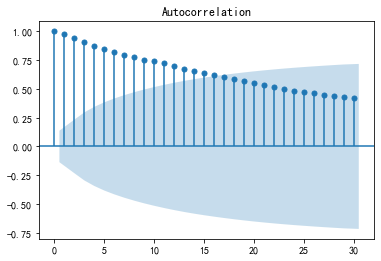

In [39]:
from statsmodels.graphics.tsaplots import plot_acf #导入自相关函数
plot_acf(ts,use_vlines=True,lags=30)  #"lags"自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图
plt.show()  #展示原始数据"ts"的自相关图

![](https://ai-studio-static-online.cdn.bcebos.com/2109270acf3f46669c6e93cd0f367af23567db829dc6450ca22a9d66eb261712)
![](https://ai-studio-static-online.cdn.bcebos.com/8eb9d5761cb9462eb07fd51131ae614fac5c8ab998ae49f58701ceba52707625)

得出数据为非平稳的，进行一阶差分处理数据

差分后的自相关图和时序图

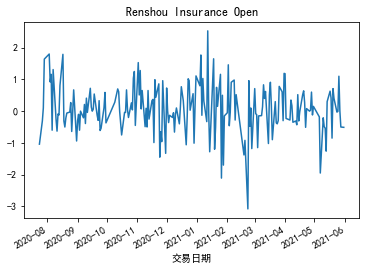

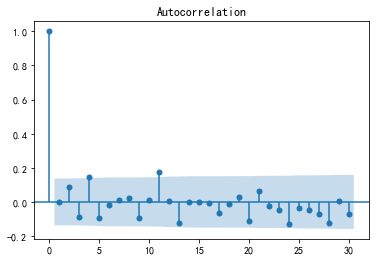

In [40]:
# 进行一阶差分
D_ts = ts.diff().dropna()   #对"ts数列"进行差分
D_ts.columns = [u'open差分']
# 绘制差分后时序图
D_ts.plot()  #绘制出差分后的时序图
plt.title("Renshou Insurance Open")  #添加图标题
plt.show()   #展示差分后的时序图

from statsmodels.graphics.tsaplots import plot_acf #导入自相关函数 # 绘制差分后自相关图与偏自相关图
plot_acf(D_ts,use_vlines=True,lags=30)  #"lags"自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图
plt.show() #展示差分后数据"D_ts"的自相关图

![](https://ai-studio-static-online.cdn.bcebos.com/6bf932d9cd9f434ab61a9abe8df2dbbeea634c2724d443118eab1a924d4feacd)
![](https://ai-studio-static-online.cdn.bcebos.com/5dd58f85a5e24f0f89fa2e976e78414f59a241772d5a4945bca40b209252a7fe)
将模型进行修正，并最终实现预测

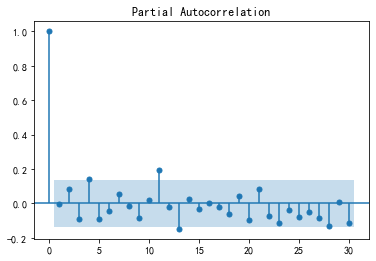

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf  #导入偏自相关函数
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
plot_pacf(D_ts,use_vlines=True,lags=30) #"lags"偏自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图
plt.show()  #展示差分后数据"D_ts"的偏自相关图
# 对差分后数据进行单位根检验
#展示差分后单位根检验结果，返回统计量和p值

#print(u'原始序列的ADF检验结果为：', ADF(D_ts))

# 对差分后数据进行白噪声检验
from statsmodels.tsa import stattools #对差分后达到平稳的数据进行白噪声检验
LjungBox=stattools.q_stat(stattools.acf(D_ts)[1:12],len(D_ts)) #展示白噪声检验结果，返回统计量和p值
LjungBox[1][-1]

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(ts,order=(1,1,0))
result=model.fit(disp=-1)
result.summary()

result.conf_int()#模型诊断

sm.tsa.arma_order_select_ic(D_ts,max_ar=6,max_ma=4,ic='aic')['aic_min_order'] #AIC确定阶数
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(ts,order=(2,1,2))
result=model.fit(disp=-1)
result.summary()

result.conf_int()  #模型诊断
print(result.conf_int())
a=result.forecast(21)
print(a[0])

完整代码如下

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy as stats
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

df=pd.read_csv('海尔智家.csv',index_col='交易日期')
#读取数据
df.head()
# df.index = pd.to_datetime(df.index)   #进行索引
df.index = pd.DatetimeIndex(df.index).to_period('d')
# df.index
ts=df['收盘价']  #时间序列的变量为"open"，并赋值给"ts "
ts=ts['2021-5-31' : '2020-7-23']
ts=ts.reindex(ts.index[::-1])
print(ts)  #读出open的前5个数据
plt.rcParams['font.sans-serif'] = ['simhei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
ts.plot()
plt.title("Renshou Insurance")  #添加图标题
plt.xticks(rotation=45)    #横坐标旋转45度
plt.xlabel('日期')   #添加图的标签（x轴，y轴）
plt.ylabel('收盘价')
# 绘制自相关图
from statsmodels.graphics.tsaplots import plot_acf #导入自相关函数
plot_acf(ts,use_vlines=True,lags=30)  #"lags"自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图
plt.show()  #展示原始数据"ts"的自相关图

#原始数据平稳性检测（单位根检验）
plot_acf(ts,use_vlines=True,lags=30)  #"lags"自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图
plt.show()  #展示原始数据"ts"的自相关图
#print(u'原始序列的ADF检验结果为：', ADF(df[u'open'])) #展示单位根检验结果
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df[u'收盘价'],autolag='AIC')
print(dftest)

# 进行一阶差分
D_ts = ts.diff().dropna()   #对"ts数列"进行差分
D_ts.columns = [u'open差分']
# 绘制差分后时序图
D_ts.plot()  #绘制出差分后的时序图
plt.title("Renshou Insurance Open")  #添加图标题
plt.show()   #展示差分后的时序图

from statsmodels.graphics.tsaplots import plot_acf #导入自相关函数 # 绘制差分后自相关图与偏自相关图
plot_acf(D_ts,use_vlines=True,lags=30)  #"lags"自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图
plt.show() #展示差分后数据"D_ts"的自相关图

from statsmodels.graphics.tsaplots import plot_pacf  #导入偏自相关函数
plot_pacf(D_ts,use_vlines=True,lags=30) #"lags"偏自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图
plt.show()  #展示差分后数据"D_ts"的偏自相关图
# 对差分后数据进行单位根检验
#展示差分后单位根检验结果，返回统计量和p值

#print(u'原始序列的ADF检验结果为：', ADF(D_ts))

# 对差分后数据进行白噪声检验
from statsmodels.tsa import stattools #对差分后达到平稳的数据进行白噪声检验
LjungBox=stattools.q_stat(stattools.acf(D_ts)[1:12],len(D_ts)) #展示白噪声检验结果，返回统计量和p值
LjungBox[1][-1]

# df.index = pd.DatetimeIndex(df.index).to_period('M')
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(ts,order=(1,1,0))
result=model.fit()
display(result.summary())

result.conf_int()#模型诊断

sm.tsa.arma_order_select_ic(D_ts,max_ar=6,max_ma=4,ic='aic')['aic_min_order'] #AIC确定阶数
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(ts,order=(2,1,2))
result=model.fit(disp=-1)
result.summary()

result.conf_int()  #模型诊断
print(result.conf_int())
a=result.forecast(21)
print(a[0])

b = pd.DataFrame(a[0])
b.to_csv(r'ARIMA-海尔智家.csv')

输出结果

[30.18498307 30.29139032 30.31976568 30.39601848 30.4635083  30.50103524
 30.5981657  30.62126297 30.71528141 30.75727243 30.8218227  30.89658233
 30.93264151 31.02545752 31.0573308  31.14035719 31.19294736 31.24965432
 31.32790171 31.36535104 31.45250655]

为6-1至6-30的股票预测值，将其存入csv文件，以便进行下一步分析。

模型评估：

In [6]:
# def mean_squared_error(y_test, y_pred):
#     return np.mean((y_test-y_pred)**2)

# def median_absolute_error(y_test,y_pred):
#     return (np.median(np.abs(y_test-y_pred)))

# def mean_squared_log_error(y_test,y_pred):
#     return (np.mean(np.abs(y_test-y_pred)))

# def mean_absolute_error(y_test,y_pred):
#     return (np.mean((np.log(y_test+1)-np.log(y_pred+1))**2))

# def explained_variance_score(y_test,y_pred):
#     return (1-np.var(y_test-y_pred)/np.var(y_test))

# def r2_score(y_test,y_pred):
#     return (1-(np.sum((y_test-y_pred)**2))/np.sum((y_test-np.mean(y_test))**2))

In [ ]:
MASE = np.mean(np.abs(valid['收盘价']-preds))/(np.mean(np.abs(np.diff(train['收盘价']))))
print('\nMASE: ',MASE)
RMSE = np.sqrt(np.mean((valid['收盘价']-preds)**2))/(np.mean(np.diff(train['收盘价'])**2))
print('\nRMSE: ',RMSE)

MASE:5.833418421941112
RMSE:6.579808365198711
![](https://ai-studio-static-online.cdn.bcebos.com/4dffc91c933644339953c2ab45cb7e5ae880fc43543949f9aee8eb65c804b0fc)


## 深度森林

In [7]:
import pandas as pd
# for normalizing data
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))

# read the file
df = pd.read_csv('海尔智家.csv')

X=df
X.drop('交易日期', axis=1, inplace=True)
X=X.values
y=df.收盘价
y=y.values

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error,accuracy_score,precision_recall_curve,f1_score

from deepforest import CascadeForestRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

model = CascadeForestRegressor(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)#prediction
mse = mean_squared_error(y_test, y_pred)
# print("\nTesting MSE: {:.3f}".format(mse))

# MASE = np.mean(np.abs(y_test-y_pred))
# print(MASE)
# RMSE = np.sqrt(np.mean((y_test-y_pred)**2))
# print(RMSE)

[2021-12-11 12:11:29.731] Start to fit the model:
[2021-12-11 12:11:29.731] Fitting cascade layer = 0 
[2021-12-11 12:11:30.071] layer = 0  | Val MSE = 0.17023 | Elapsed = 0.340 s
[2021-12-11 12:11:30.072] Fitting cascade layer = 1 
[2021-12-11 12:11:30.412] layer = 1  | Val MSE = 0.16204 | Elapsed = 0.339 s
[2021-12-11 12:11:30.413] Fitting cascade layer = 2 
[2021-12-11 12:11:30.764] layer = 2  | Val MSE = 0.14512 | Elapsed = 0.351 s
[2021-12-11 12:11:30.764] Fitting cascade layer = 3 
[2021-12-11 12:11:31.143] layer = 3  | Val MSE = 0.15603 | Elapsed = 0.379 s
[2021-12-11 12:11:31.143] Early stopping counter: 1 out of 2
[2021-12-11 12:11:31.143] Fitting cascade layer = 4 
[2021-12-11 12:11:31.512] layer = 4  | Val MSE = 0.15864 | Elapsed = 0.370 s
[2021-12-11 12:11:31.512] Early stopping counter: 2 out of 2
[2021-12-11 12:11:31.512] Handling early stopping
[2021-12-11 12:11:31.513] The optimal number of layers: 3
[2021-12-11 12:11:31.515] Start to evalute the model:
[2021-12-11 12:1

# Score of deepforest
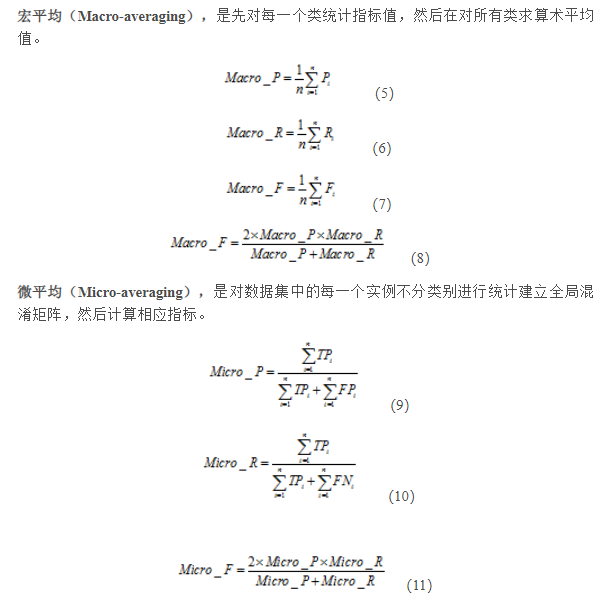

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_squared_log_error,median_absolute_error,mean_absolute_error,precision_score,r2_score,explained_variance_score,recall_score

from deepforest import CascadeForestRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

model = CascadeForestRegressor(random_state = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)#prediction
#scores
mse = mean_squared_error(y_test, y_pred)
mdae = median_absolute_error(y_test,y_pred)
msle = mean_squared_log_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
evs = explained_variance_score(y_test,y_pred)
# acc = model.calc_accuracy(y_test, y_pred) * 100
# print("\nTesting ACC: {:.3f} %".format(acc))
r2 = r2_score(y_test,y_pred)
print("\nTesting MSE: {:10f}".format(mse))
print("\nTesting MDAE: {:.10f}".format(mdae))
print("\nTesting MSLE: {:.10f}".format(msle))
print("\nTesting MAE: {:.10f}".format(mae))
print("\nTesting EVS: {:.10f}".format(evs))
print("\nTesting R2: {:.10f}".format(r2))
MASE = np.mean(np.abs(y_test-y_pred))
print(MASE)
RMSE = np.sqrt(np.mean((y_test-y_pred)**2))
print(RMSE)

# from sklearn.metrics import precision_recall_curve
# #Macro-averaging
# recall_ma = recall_score(y_test,y_pred,average='macro')
# precision_ma = precision_score(y_test, y_pred, average='macro')
# plt.plot(recall_ma,precision_ma)
# plt.title("R&P_macro")  #添加图标题
# # plt.xticks(rotation=45)    #横坐标旋转45度
# plt.xlabel('Recall')   #添加图的标签（x轴，y轴）
# plt.ylabel('Precision')

# #Micro-averaging
# recall_mi = metrics.recall(y_test,y_pred,average='micro')
# precision_mi = metrics.precision_score(y_test, y_pred, average='micro')
# plt.plot(recall_mi,precision_mi)
# plt.title("R&P_micro")  #添加图标题
# # plt.xticks(rotation=45)    #横坐标旋转45度
# plt.xlabel('Recall')   #添加图的标签（x轴，y轴）
# plt.ylabel('Precision')

# plt.show()

[2021-12-11 12:43:15.691] Start to fit the model:
[2021-12-11 12:43:15.692] Fitting cascade layer = 0 
[2021-12-11 12:43:16.063] layer = 0  | Val MSE = 0.17023 | Elapsed = 0.371 s
[2021-12-11 12:43:16.064] Fitting cascade layer = 1 
[2021-12-11 12:43:16.401] layer = 1  | Val MSE = 0.16204 | Elapsed = 0.337 s
[2021-12-11 12:43:16.401] Fitting cascade layer = 2 
[2021-12-11 12:43:16.784] layer = 2  | Val MSE = 0.14512 | Elapsed = 0.383 s
[2021-12-11 12:43:16.784] Fitting cascade layer = 3 
[2021-12-11 12:43:17.152] layer = 3  | Val MSE = 0.15603 | Elapsed = 0.368 s
[2021-12-11 12:43:17.152] Early stopping counter: 1 out of 2
[2021-12-11 12:43:17.153] Fitting cascade layer = 4 
[2021-12-11 12:43:17.511] layer = 4  | Val MSE = 0.15864 | Elapsed = 0.358 s
[2021-12-11 12:43:17.511] Early stopping counter: 2 out of 2
[2021-12-11 12:43:17.511] Handling early stopping
[2021-12-11 12:43:17.512] The optimal number of layers: 3
[2021-12-11 12:43:17.513] Start to evalute the model:
[2021-12-11 12:4

输出结果 [[31.280825] [18.242475][21.952375][34.3124  ][29.345925][23.1045  ][32.77065 ][22.187925][25.842   ][27.278575][22.743475][24.25955 ] [33.739725] [34.254025] [28.129475] [18.209225][22.95175 ] [28.0267  ][18.1498  ] [22.5589  ] [30.19165 ] [28.070425] [22.7747  ] [34.0159  ] [34.51575 ] [34.224425] [32.170775] [31.281275] [21.166175] [22.72335 ] [29.054675] [32.52695 ] [22.16615 ] [30.261575][20.98835 ] [30.94195 ] [29.224   ] [26.4048  ] [29.700675] [33.98955 ] [28.159225] [32.051725] [29.69675 ] [29.022725] [29.782875] [25.2671  ] [28.596775] [27.509725] [27.903625] [28.157875] [32.867325] [23.94025 ] [22.17805 ] [22.866825] [22.7493  ] [28.247825] [25.82665 ] [26.297975] [18.4542  ]]

为6-1至6-30的股票预测值，将其存入csv文件，以便进行下一步分析。

模型评估：


Testing MSE: 0.169
MASE :5.335877714324106
RMSE:6.62123447979003

![](https://ai-studio-static-online.cdn.bcebos.com/ce20e9d4733847e58af92bdfcfcc7fbcfc39ae7a10b244d1a4faa4e928f7a405)
![](https://ai-studio-static-online.cdn.bcebos.com/df0fa1f42fde4075a6cc1b7d3e8c328178899a889817434a9d6af1f6f1173f86)


## 随机森林
首先定义森林必须参数

In [ ]:
trees=10 #CART回归树的个数
n_features=7 #特征个数
max_depth=20 #树的最大深度

读取数据

In [ ]:
def loadCsvDataSet(fileName='C:\\Users\\lwb\\Desktop\\data'):
    csv_path=os.path.join(fileName,"海尔智家.csv")
    df=pd.read_csv(csv_path)
    #print(df.values)
    return df.values


将数据集以五月三十一为分界线，划分测试集与训练集，并将其分裂

In [ ]:
def split_train_test_data(dataSet):
    #第五列是adj close
    #即DataSet中取出feature列的值大于value的行，赋值给mat0，
    X_train=dataSet[np.nonzero(dataSet[:,0]<'2021-05-31')[0],:]
    X_test=dataSet[np.nonzero(dataSet[:,0]>'2021-05-31')[0],:]
    y_train=X_train[:,4]
    X_test = X_test[15:]
    y_test=X_test[:,4]
    return X_train,X_test,y_train,y_test
def binSplitDataSet(dataSet,feature,value):
    mat0=dataSet[np.nonzero(dataSet[:,feature]>value)[0],:]
    mat1=dataSet[np.nonzero(dataSet[:,feature]<value)[0],:]
    return mat0,mat1

数学准备，方差及平均值函数

In [ ]:
#计算方差
def regErr(dataSet):
    return np.var(dataSet[:,4])*shape(dataSet)[0]
#计算平均值
def regLeaf(dataSet):
    return np.mean(dataSet[:,4])


选取分割的最优特征

In [ ]:
def chooseBestSplit(dataSet, n_features):
    # 随机森林不需要进行剪枝
    f = dataSet.shape[1]  # shape[0]是指dataset的行数，估计1是指dataset的列数
    index = []
    bestS = inf
    best_feature, bestValue = 0, 0
    S = regErr(dataSet)  # 回归用于计算方差
    a=0
    ##print(S)
    for i in range(n_features):
        # 从dataset的列数f的范围内有放回地取n_features个数，放到index集合里
        index.append(np.random.randint(f))  # index里存储着所有取出来的行数集合
    # 尝试index次分割，每次分割的特征是feature列
    ##print(index)
    for feature in index:
        for splitVal in set(dataSet[:,feature]):  # set是无序无重复的集合，即把dataSet里的数据去除重复值，遍历dataSet里feature列中不重复的数值，逐个数尝试，有没有哪个数用于分割是最优的（最优的意思是：划分后得到的两部分内部区别最小，即类内方差最小）
            # 这个binSplitDataSet是上面定义的用于把数据集分为两份的函数
            mat0, mat1 = binSplitDataSet(dataSet, feature, splitVal)
            try:
                newS = regErr(mat0) + regErr(mat1)  # regErr是求方差

                if bestS > newS:  # 如果新的news比最优的s小，就把数据更新
                    bestfeature = feature
                # splitVal是在feature列下不同的值的数字之一,是切分数据的value
                    bestValue = splitVal
                    bestS = newS
            except ZeroDivisionError:
                pass
            continue
    if (shape(mat0)[0] < 10) or (shape(mat1)[0] < 10):
    # print(regLeaf(dataSet))
        return None, regLeaf(dataSet)
    ##print(bestValue)
    return bestfeature, bestValue

递归实现树并构建森林

In [ ]:
def createTree(dataSet, n_features, max_depth):
    bestfeature, bestValue = chooseBestSplit(dataSet, n_features)
    if bestfeature == None:
        # print(bestValue)
        return bestValue
    retTree = {}  # retTree中存储着一泼CART回归树
    max_depth -= 1
    if max_depth < 0:  # 控制树的深度
        return regLeaf(dataSet)  # regLeaf是算平均值的函数
    retTree['bestFeature'] = bestfeature
    retTree['bestVal'] = bestValue
    lSet, rSet = binSplitDataSet(dataSet, bestfeature, bestValue)
    retTree['right'] = createTree(rSet, n_features, max_depth)
    retTree['left'] = createTree(lSet, n_features, max_depth)
    return retTree


# 创建n棵树
# 最后将X_train调用createTree存储到Trees中。
# 返回Trees.Tress里存储的就是n课树
def RandomForest(trees,n_features, max_depth):  # 这个n应该就是树的个数

    Trees = []
    for i in range(trees):
        Trees.append((createTree(X_train,n_features,max_depth)))
        # 构件训练数据的树
    return Trees

进行回归预测

In [ ]:
# 先判断树是不是一个字典，如果不是就到达结束递归的条件，返回tree转化成float的值
# 如果是一个字典：继续
# 如果data中，tree的bestFeature为下标的数值大于tree的bestVal
# 判断左树是否是float类型，是就返回tree的左树
# 否则就从左树继续递归
# 否则
# 判断右树是否是float类型，是就返回tree的右树
# 不是float类型就从树的右树进行递归
def TreeForecast(tree, data):
    if not isinstance(tree, dict):  # isinstance是判断tree是否是一个字典类型，
        # print(type(tree))
        # print(float(tree))
        return float(tree)
    if data[tree['bestFeature']] > tree['bestVal']:
        if type(tree['left']) == 'float':
            return tree['left']
        else:
            return TreeForecast(tree['left'], data)
    else:
        if type(tree['right']) == 'float':
            return tree['right']
        else:
            return TreeForecast(tree['right'], data)


# 单棵树预测测试集 调用TreeForecast 单个数据集预测样本
# 创建一个n行1列的浮点型的数组
# 数组里的每一行都用TreeForecast单个数据集预测，赋值给yhat相应列
def createForeCast(tree, dataSet):
    n = len(dataSet)
    # np.mat将数据转换成浮点型
    yhat = np.mat(zeros((n, 1)))  # 创建一个m行1列的浮点型数组
    for i in range(n):
        yhat[i, 0] = TreeForecast(tree, dataSet[i, :])
        # print(yhat[i,0])
    return yhat
#随机森林预测
#遍历每棵树进行预测，取所有树预测出的数据的平均值为预测值
def Predict(Trees,dataSet):
    n=len(dataSet)
    yhat=np.mat(zeros((n,1))) #创造一个n行1列的初始化为0的浮点型数组
    for tree in Trees: #trees里面有n棵树，用每棵树都预测一次  yhat中存储着每棵树的预测数值
        yhat+=createForeCast(tree,dataSet)#createForecast返回的是一个数组
    yhat/=len(Trees)#求出每个数除以树棵树的平均值
    return yhat

完整代码如下

In [ ]:
import numpy as np
from numpy import *
import os
import pandas as pd
import random
#自定义参数

trees=10 #CART回归树的个数
n_features=7 #特征个数
max_depth=20 #树的最大深度
#读入数据 这样路径和文件名分开写，方便以后将整个文件夹的数据导入进来。
def loadCsvDataSet(fileName=''):
    csv_path=os.path.join(fileName,"海尔智家.csv")
    df=pd.read_csv(csv_path)
    #print(df.values)
    return df.values
#把dataset划分成训练数据和测试数据

def split_train_test_data(dataSet):
    #第五列是adj close
    #即DataSet中取出feature列的值大于value的行，赋值给mat0，
    X_train=dataSet[np.nonzero(dataSet[:,0]<'2021-05-31')[0],:]
    X_test=dataSet[np.nonzero(dataSet[:,0]>'2021-05-31')[0],:]
    y_train=X_train[:,4]
    X_test = X_test[15:]
    y_test=X_test[:,4]
    return X_train,X_test,y_train,y_test
def binSplitDataSet(dataSet,feature,value):
    mat0=dataSet[np.nonzero(dataSet[:,feature]>value)[0],:]
    mat1=dataSet[np.nonzero(dataSet[:,feature]<value)[0],:]
    return mat0,mat1
#计算方差
def regErr(dataSet):
    return np.var(dataSet[:,4])*shape(dataSet)[0]
#计算平均值
def regLeaf(dataSet):
    return np.mean(dataSet[:,4])



def chooseBestSplit(dataSet, n_features):
    # 随机森林不需要进行剪枝
    f = dataSet.shape[1]  # shape[0]是指dataset的行数，估计1是指dataset的列数
    index = []
    bestS = inf
    best_feature, bestValue = 0, 0
    S = regErr(dataSet)  # 回归用于计算方差
    a=0
    ##print(S)
    for i in range(n_features):
        # 从dataset的列数f的范围内有放回地取n_features个数，放到index集合里
        index.append(np.random.randint(f))  # index里存储着所有取出来的行数集合
    # 尝试index次分割，每次分割的特征是feature列
    ##print(index)
    for feature in index:
        for splitVal in set(dataSet[:,feature]):  # set是无序无重复的集合，即把dataSet里的数据去除重复值，遍历dataSet里feature列中不重复的数值，逐个数尝试，有没有哪个数用于分割是最优的（最优的意思是：划分后得到的两部分内部区别最小，即类内方差最小）
            # 这个binSplitDataSet是上面定义的用于把数据集分为两份的函数
            mat0, mat1 = binSplitDataSet(dataSet, feature, splitVal)
            try:
                newS = regErr(mat0) + regErr(mat1)  # regErr是求方差

                if bestS > newS:  # 如果新的news比最优的s小，就把数据更新
                    bestfeature = feature
                # splitVal是在feature列下不同的值的数字之一,是切分数据的value
                    bestValue = splitVal
                    bestS = newS
            except ZeroDivisionError:
                pass
            continue
    if (shape(mat0)[0] < 10) or (shape(mat1)[0] < 10):
    # print(regLeaf(dataSet))
        return None, regLeaf(dataSet)
    ##print(bestValue)
    return bestfeature, bestValue


# 实现树 这里使用递归
# 首先调用chooseBestSplit得到返回值bestfeature和bestValue
# 然后建立左右子树
# 如果深度到指定深度，就返回剩余dataSet的平均值。
# retTree是一个字典，有'bestFeature' 'bestVal' 'right'和'left'
# 返回retree
def createTree(dataSet, n_features, max_depth):
    bestfeature, bestValue = chooseBestSplit(dataSet, n_features)
    if bestfeature == None:
        # print(bestValue)
        return bestValue
    retTree = {}  # retTree中存储着一泼CART回归树
    max_depth -= 1
    if max_depth < 0:  # 控制树的深度
        return regLeaf(dataSet)  # regLeaf是算平均值的函数
    retTree['bestFeature'] = bestfeature
    retTree['bestVal'] = bestValue
    lSet, rSet = binSplitDataSet(dataSet, bestfeature, bestValue)
    retTree['right'] = createTree(rSet, n_features, max_depth)
    retTree['left'] = createTree(lSet, n_features, max_depth)
    return retTree


# 创建n棵树
# 最后将X_train调用createTree存储到Trees中。
# 返回Trees.Tress里存储的就是n课树
def RandomForest(trees,n_features, max_depth):  # 这个n应该就是树的个数

    Trees = []
    for i in range(trees):
        Trees.append((createTree(X_train,n_features,max_depth)))
        # 构件训练数据的树
    return Trees


# 预测单个数据样本 #这里也用递归

# 先判断树是不是一个字典，如果不是就到达结束递归的条件，返回tree转化成float的值
# 如果是一个字典：继续
# 如果data中，tree的bestFeature为下标的数值大于tree的bestVal
# 判断左树是否是float类型，是就返回tree的左树
# 否则就从左树继续递归
# 否则
# 判断右树是否是float类型，是就返回tree的右树
# 不是float类型就从树的右树进行递归
def TreeForecast(tree, data):
    if not isinstance(tree, dict):  # isinstance是判断tree是否是一个字典类型，
        # print(type(tree))
        # print(float(tree))
        return float(tree)
    if data[tree['bestFeature']] > tree['bestVal']:
        if type(tree['left']) == 'float':
            return tree['left']
        else:
            return TreeForecast(tree['left'], data)
    else:
        if type(tree['right']) == 'float':
            return tree['right']
        else:
            return TreeForecast(tree['right'], data)


# 单棵树预测测试集 调用TreeForecast 单个数据集预测样本
# 创建一个n行1列的浮点型的数组
# 数组里的每一行都用TreeForecast单个数据集预测，赋值给yhat相应列
def createForeCast(tree, dataSet):
    n = len(dataSet)
    # np.mat将数据转换成浮点型
    yhat = np.mat(zeros((n, 1)))  # 创建一个m行1列的浮点型数组
    for i in range(n):
        yhat[i, 0] = TreeForecast(tree, dataSet[i, :])
        # print(yhat[i,0])
    return yhat
#随机森林预测
#遍历每棵树进行预测，取所有树预测出的数据的平均值为预测值
def Predict(Trees,dataSet):
    n=len(dataSet)
    yhat=np.mat(zeros((n,1))) #创造一个n行1列的初始化为0的浮点型数组
    for tree in Trees: #trees里面有n棵树，用每棵树都预测一次  yhat中存储着每棵树的预测数值
        yhat+=createForeCast(tree,dataSet)#createForecast返回的是一个数组
    yhat/=len(Trees)#求出每个数除以树棵树的平均值
    return yhat


loadCsvDataSet=loadCsvDataSet()
dataSet=loadCsvDataSet
X_train,X_test,y_train,y_test=split_train_test_data(dataSet)
BestSplit=chooseBestSplit(X_train,n_features)
##print(X_test)
RF=RandomForest(trees,n_features, max_depth)
yhat=Predict(RF,X_test)
#yhat=sorted(set(yhat),key=yhat.index) # sorted output
print(yhat)
print(y_test)
#yhat=yhat.reverse()
yhat = pd.DataFrame(yhat)
yhat=yhat.reindex(index=yhat.index[::-1])
yhat.to_csv(r'随机森林-海尔智家.csv')


输出结果

[25.91 25.86 26.48 26.56 26.19 26.52 25.87 25.51 26.31 26.55 27.1 26.87
 27.84 28.25 28.53 28.74 29.12 29.54 29.61 30.3 29.95]

为6-1至6-30的股票预测值，将其存入csv文件，以便进行下一步分析。

模型评估：

In [3]:
import numpy as np 

In [5]:
MASE = np.mean(np.abs(valid['收盘价']-preds))/(np.mean(np.abs(np.diff(train['收盘价']))))
print(MASE)

NameError: name 'valid' is not defined

得出：

MASE：3.0460506597208132

![](https://ai-studio-static-online.cdn.bcebos.com/19c5928e8bc04ad7bb009d605572356c3c112ebe1b554b5085cb93d8d03f492a)


## 移动平均

使用移动平均法，而不是使用简单的平均值，移动平均法使用最近的一组数据计算预测值。即对于后续的每个新的时间，在考虑预测值时，将从集合中删除最早的观测值，并加入上一个观测值。

![](https://ai-studio-static-online.cdn.bcebos.com/9dc4addf45524ae1baa280355b61ec67483bb107e8194ef1b0476548fd755061)

创建训练集与测试集

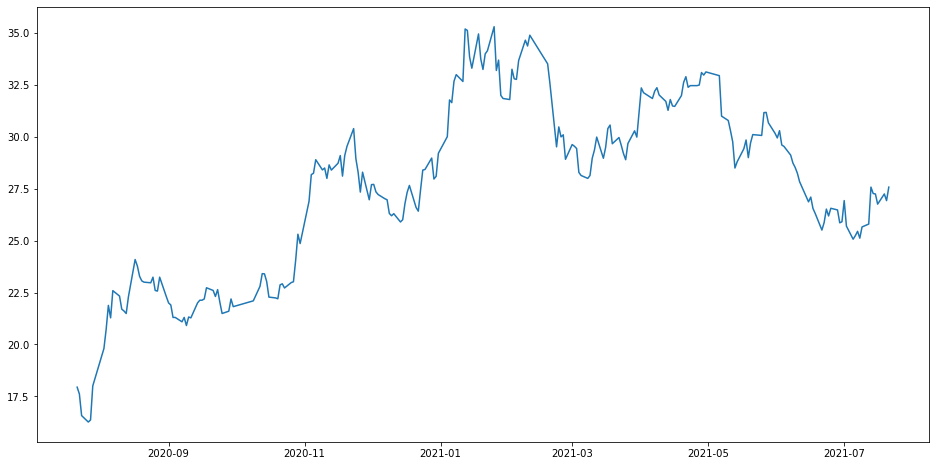

In [8]:
df = pd.read_csv('海尔智家.csv')
# print the head
df.head()
# setting index as 交易日期
df['交易日期'] = pd.to_datetime(df.交易日期, format='%Y-%m-%d')
df.index = df['交易日期']
# plot
plt.figure(figsize=(16, 8))
plt.plot(df['收盘价'], label='收盘价 Price history')
# creating dataframe with 交易日期 and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['交易日期', '收盘价'])
for i in range(0, len(data)):
    new_data['交易日期'][i] = data['交易日期'][i]
    new_data['收盘价'][i] = data['收盘价'][i]
# splitting into train and validation
train = new_data[:208]
valid = new_data[208:229]

进行预测

In [9]:
preds = []
for i in range(0,21):
    a = train['收盘价'][len(train)-21+i:].sum() + sum(preds)
    b = a/21
    preds.append(b)
print(preds)

[30.33, 30.196666666666665, 30.065555555555555, 30.0210582010582, 29.984441924918116, 29.96941534991422, 29.97938750943394, 30.049834533692703, 30.109350463868548, 30.141700485957525, 30.155590985288832, 30.21061912744544, 30.234458133514273, 30.240384711300674, 30.248022078505464, 30.256499320339056, 30.21299928797425, 30.16695163502065, 30.142520760497817, 30.141212225283432, 30.150317569344544]


完整代码如下：

[30.607619047619043, 30.488934240362806, 30.370312061332463, 30.238898349967343, 30.109798271394364, 30.06740771288933, 30.032998556360255, 30.02028420190122, 30.03267868770604, 30.10566338712061, 30.167837834126356, 30.202972969084755, 30.219781205707836, 30.277866025027258, 30.304907264314267, 30.314188562614948, 30.325340398929946, 30.33749946554566, 30.29785658295259, 30.255849753569382, 30.235652122786966]


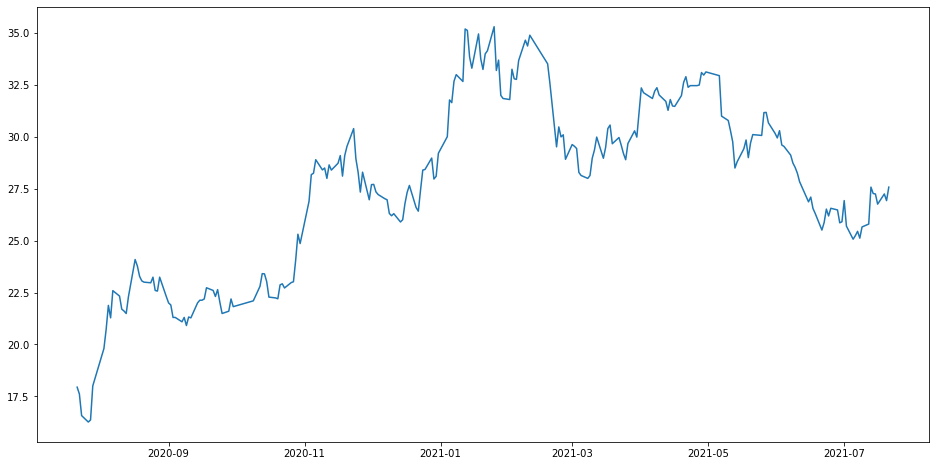

In [10]:
# import packages
import pandas as pd
import numpy as np
import time
# to plot within notebook
import matplotlib.pyplot as plt
#% matplotlib inline

# setting figure size
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 20, 10

# for normalizing data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# read the file
df = pd.read_csv('海尔智家.csv')
# print the head
df.head()
# setting index as 交易日期
df['交易日期'] = pd.to_datetime(df.交易日期, format='%Y-%m-%d')
df.index = df['交易日期']
# plot
plt.figure(figsize=(16, 8))
plt.plot(df['收盘价'], label='收盘价 Price history')
# creating dataframe with 交易日期 and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['交易日期', '收盘价'])
for i in range(0, len(data)):
    new_data['交易日期'][i] = data['交易日期'][i]
    new_data['收盘价'][i] = data['收盘价'][i]
# splitting into train and validation
train = new_data[:206]
valid = new_data[206:227]
#print(valid)
#new_data.shape, train.shape, valid.shape((240, 2), (200, 2), (40, 2))
##train['交易日期'].min(), train['交易日期'].max(), valid['交易日期'].min(), valid['交易日期'].max()(Timestamp('2013-10-08 00:00:00'),Timestamp('2017-10-06 00:00:00'),Timestamp('2017-10-09 00:00:00'),Timestamp('2018-10-08 00:00:00'))
#make predictions
preds = []
for i in range(0,21):
    a = train['收盘价'][len(train)-21+i:].sum() + sum(preds)
    b = a/21
    preds.append(b)
print(preds)


preds = pd.DataFrame(preds)
preds.to_csv(r'移动平均-海尔智家.csv')

输出结果

[30.607619047619043, 30.488934240362806, 30.370312061332463, 30.238898349967343, 30.109798271394364, 30.06740771288933, 30.032998556360255, 30.02028420190122, 30.03267868770604, 30.10566338712061, 30.167837834126356, 30.202972969084755, 30.219781205707836, 30.277866025027258, 30.304907264314267, 30.314188562614948, 30.325340398929946, 30.33749946554566, 30.29785658295259, 30.255849753569382, 30.235652122786966]

为6-1至6-30的股票预测值，将其存入csv文件，以便进行下一步分析。

模型评估：

In [11]:
MASE = np.mean(np.abs(valid['收盘价']-preds))/(np.mean(np.abs(np.diff(train['收盘价']))))
print(MASE)
RMSE = np.sqrt(np.mean((valid['收盘价']-preds)**2))/(np.mean(np.diff(train['收盘价'])**2))
print(RMSE)

0     NaN
206   NaN
207   NaN
208   NaN
209   NaN
210   NaN
211   NaN
212   NaN
213   NaN
214   NaN
215   NaN
216   NaN
217   NaN
218   NaN
219   NaN
220   NaN
221   NaN
222   NaN
223   NaN
224   NaN
225   NaN
226   NaN
dtype: float64
0     NaN
206   NaN
207   NaN
208   NaN
209   NaN
210   NaN
211   NaN
212   NaN
213   NaN
214   NaN
215   NaN
216   NaN
217   NaN
218   NaN
219   NaN
220   NaN
221   NaN
222   NaN
223   NaN
224   NaN
225   NaN
226   NaN
dtype: float64


得出：

MASE：4.803083615475988
RMSE：5.388559541879466

![](https://ai-studio-static-online.cdn.bcebos.com/ce20e9d4733847e58af92bdfcfcc7fbcfc39ae7a10b244d1a4faa4e928f7a405)
![](https://ai-studio-static-online.cdn.bcebos.com/df0fa1f42fde4075a6cc1b7d3e8c328178899a889817434a9d6af1f6f1173f86)


## KNN

考虑将除时间外的特征作为近邻，建立KNN模型

首先划分训练集与测试集

In [ ]:
df = pd.read_csv('海尔智家.csv')
# print the head
df.head()

df.index = df['交易日期']
##print(df.交易日期)
# sorting
data = df.sort_index(ascending=True, axis=0)
# creating a separate dataset
new_data = pd.DataFrame(index=range(0, len(df)), columns=['开盘价','最高价','最低价','收盘价','成交数量(股)','成交金额(元)'])
for i in range(0, len(data)):
    new_data['开盘价'][i] = data['开盘价'][i]
    new_data['最高价'][i] = data['最高价'][i]
    new_data['最低价'][i] = data['最低价'][i]
    new_data['收盘价'][i] = data['收盘价'][i]
    new_data['成交数量(股)'][i] = data['成交数量(股)'][i]
    new_data['成交金额(元)'][i] = data['成交金额(元)'][i]
train = new_data[:206]
valid = new_data[206:227]
print(valid)
x_train = train.drop('收盘价', axis=1)
y_train = train['收盘价']
x_valid = valid.drop('收盘价', axis=1)
y_valid = valid['收盘价']

实现KNN

In [ ]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

# using gridsearch to find the best parameter
params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)

# fit the model and make predictions
model.fit(x_train, y_train)
preds = model.predict(x_valid)
print(preds)

完整代码如下

In [ ]:
# import packages
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 20, 10
# for normalizing data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
# read the file
df = pd.read_csv('海尔智家.csv')
# print the head
df.head()

df.index = df['交易日期']
##print(df.交易日期)
# sorting
data = df.sort_index(ascending=True, axis=0)
# creating a separate dataset
new_data = pd.DataFrame(index=range(0, len(df)), columns=['开盘价','最高价','最低价','收盘价','成交数量(股)','成交金额(元)'])
for i in range(0, len(data)):
    new_data['开盘价'][i] = data['开盘价'][i]
    new_data['最高价'][i] = data['最高价'][i]
    new_data['最低价'][i] = data['最低价'][i]
    new_data['收盘价'][i] = data['收盘价'][i]
    new_data['成交数量(股)'][i] = data['成交数量(股)'][i]
    new_data['成交金额(元)'][i] = data['成交金额(元)'][i]
train = new_data[:206]
valid = new_data[206:227]
print(valid)
x_train = train.drop('收盘价', axis=1)
y_train = train['收盘价']
x_valid = valid.drop('收盘价', axis=1)
y_valid = valid['收盘价']
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

# using gridsearch to find the best parameter
params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)

# fit the model and make predictions
model.fit(x_train, y_train)
preds = model.predict(x_valid)
print(preds)


preds = pd.DataFrame(preds)
preds.to_csv(r'KNN-海尔智家.csv')


输出结果：

[33.17666666666667 34.300000000000004 32.82333333333333 32.666666666666664
 31.81 29.30333333333333 29.75 28.290000000000003 25.95 21.73
 22.566666666666666 22.653333333333336 21.73 19.69333333333333 21.73
 18.12333333333333 21.17 17.37333333333333 21.17 18.12333333333333
 16.853333333333335]

为6-1至6-30的股票预测值，将其存入csv文件，以便进行下一步分析。

模型评估：

In [ ]:
MASE = np.mean(np.abs(valid['收盘价']-preds))/(np.mean(np.abs(np.diff(train['收盘价']))))
print(MASE)
RMSE = np.sqrt(np.mean((valid['收盘价']-preds)**2))/(np.mean(np.diff(train['收盘价'])**2))
print(RMSE)

得出：

MASE:7.763281593315024
RMSE:8.799712359092396

![](https://ai-studio-static-online.cdn.bcebos.com/e36274f72f0a4c5090ad31ab8306c499ce967778f919436b9705ceaf95383ce9)
![](https://ai-studio-static-online.cdn.bcebos.com/49ed943064134f9dbbd21fffd17fbb4963eec3eba22a4d97819afb89eddfb6aa)


In [41]:
# def get_technical_indicators(dataset):
    
#     #Create 7 and 21 days Moving Average
#     dataset['ma7'] = dataset['收盘价'].rolling(window = 7).mean()
#     dataset['ma21'] = dataset['收盘价'].rolling(window = 21).mean()
    
#     #Create MACD
#     dataset['26ema'] = dataset['收盘价'].ewm(span = 26).mean()
#     dataset['12ema'] = dataset['收盘价'].ewm(span = 12).mean()
#     dataset['MACD'] = (dataset['12ema'] - dataset['26ema'])
    
#     #Create Bollinger Bands
#     dataset['20sd'] = dataset['收盘价'].rolling(window = 20).std()
#     dataset['upper_band'] = (dataset['收盘价'].rolling(window = 20).mean()) + (dataset['20sd']*2)
#     dataset['lower_band'] = (dataset['收盘价'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    
#     #Create Exponential moving average
#     dataset['ema'] = dataset['收盘价'].ewm(com = 0.5).mean()
    
#     #Create Momentum
#     dataset['momentum'] = (dataset['收盘价']/100) - 1

# XGBoot

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [44]:
scaler = MinMaxScaler(feature_range=(0,1))
#read the file
df = pd.read_csv('海尔智家.csv')
#print the head
df.head()
df.index = df['交易日期']
#sorting
data = df.sort_index(ascending = True, axis = 0)
# creating a separate dataset
new_data = pd.DataFrame(index = range(0,len(df)), columns = ['开盘价','最高价','最低价','收盘价','成交数量(股)','成交金额(元)'])
#assign the newdata with original data
for i in range(0,len(data)):
    new_data['开盘价'][i] = data['开盘价'][i]
    new_data['最高价'][i] = data['最高价'][i]
    new_data['最低价'][i] = data['最低价'][i]
    new_data['收盘价'][i] = data['收盘价'][i]
    new_data['成交数量(股)'][i] = data['成交数量(股)'][i]
    new_data['成交金额(元)'][i] = data['成交金额(元)'][i]
train = new_data[:206]
valid = new_data[206:227]
#print(valid)
#set train and valild
x_train = train.drop('收盘价',axis=1)
y_train = train['收盘价']
x_valid = valid.drop('收盘价',axis=1)
y_valid = valid['收盘价']

In [45]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#read the file
df = pd.read_csv('海尔智家.csv')
# get_technical_indicators(df)
#data procession 
df = df.fillna(0)
X = df
X.drop('交易日期', axis = 1, inplace = True)
y = df.收盘价
y = y.values
X.drop('收盘价',axis = 1, inplace = True)
X = X.values

#splite the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

#recall function 
model = XGBRegressor(random_stste=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)#prediction
#scores
mse = mean_squared_error(y_test, y_pred)
mdae = median_absolute_error(y_test,y_pred)
msle = mean_squared_log_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
evs = explained_variance_score(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
print("\nTesting MSE: {:10f}".format(mse))
print("\nTesting MDAE: {:.10f}".format(mdae))
print("\nTesting MSLE: {:.10f}".format(msle))
print("\nTesting MAE: {:.10f}".format(mae))
print("\nTesting EVS: {:.10f}".format(evs))
print("\nTesting R2: {:.10f}".format(r2))
MASE = np.mean(np.abs(y_test-y_pred))
print(MASE)
RMSE = np.sqrt(np.mean((y_test-y_pred)**2))
print(RMSE)

[22:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "random_stste" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Testing MSE:   0.398230

Testing MDAE: 0.2980465698

Testing MSLE: 0.0007309327

Testing MAE: 0.4471144417

Testing EVS: 0.9825838244

Testing R2: 0.9825831887
0.44711444166840086
0.6310548586950889


## 时间序列方法

这里使用的时间序列方法为SBRANA教授上课所讲授的方法

### ForAR1c

In [ ]:
import numpy as np
from scipy import optimize
def ForAR1c(y, steps):
    def sseAR1c(param):
        constant = param[0]
        phi = param[1]
        e=np.zeros(len(y))
        for i in range(1,len(y)):
            e[i] = y[i] - constant - phi*y[i-1]
        return np.sum(e**2)
    results=optimize.minimize(sseAR1c,[.2,.8])
    constant=results['x'][0]
    phi=results['x'][1]
    forcasts=np.zeros(steps)
    forcasts[0]=constant+phi*y[len(y)-1]
    if steps>1:
        for i in range(1,steps):
            forcasts[i] = constant+phi*forcasts[i-1]
    return forcasts

### WMA

In [ ]:
import numpy as np
from scipy import optimize
def WMA(y, steps):
    def Weighting(param):
        param=np.abs(param)/np.sum(np.abs(param))
        yf=np.zeros(len(y))
        e=np.zeros(len(y))
        for i in range(q,len(y)):
            yf[i]=sum(param[0:(q-1)]*y[(i-q):(i-1)])
            e[i]=y[i]-yf[i]
        return np.log(np.sum(e**2))+(2*len(param)/len(y))
    AIC=np.zeros(10)
    pa=[]
    for g in range(2,10):
        q=g
        res=optimize.minimize(Weighting,np.repeat(1/q,q))
        AIC[g]=res['x'][1]
        pa.append(np.abs(res['x'][0]/np.sum(np.abs(res['x'][0]))))
    q=np.argmin(AIC)
    print()
    param=pa[q-2]

    return np.repeat(sum(param*y[(len(y)-q+1):(len(y)-1)]),steps)


### SMA

In [ ]:
def SMA(y, steps):
    sse= np.zeros(5)
    for k in range(1,6):
        sma = np.zeros(len(y))      
        for i in range( k, len(y) ):
            sma[i - k]= np.mean(y[(i - k):i ])
        sse[k - 1] = sum((sma[0:(len(y)-k-1)] - y[(k + 1):(len(y))]) ** 2)
    k=np.argmin(sse)+1
    return np.repeat(np.mean(y[-k:]),steps) 

### ForARMA11c

In [ ]:
def ForARMA11c(y, steps):
    def sseARMA11c(myparam):
        constant = myparam[0]
        phi = myparam[1]
        theta = myparam[2]
        e = np.zeros(len(y))
        for i in range(1, len(y)):
            e[i] = y[i] - constant - phi * y[i - 1]-theta*e[i-1]
        return np.sum(e ** 2)

    results = optimize.minimize(sseARMA11c, [1,.5, .3])
    constant = results['x'][0]
    phi = results['x'][1]
    theta = results['x'][2]
    e = np.zeros(len(y))
    ARMA = np.zeros(len(y))
    ARMA[0] = constant
    for i in range(1, len(y)):
        e[i] = y[i] - constant - phi * y[i - 1] - theta * e[i - 1]
        ARMA[i] = constant + phi * y[i - 1] + theta * e[i - 1]
    forecasts = np.zeros(steps)
    forecasts[0] = constant + phi * y[len(y)-1] + theta * e[len(y)-1]
    if steps>1:
        for i in range(1,steps):
            forecasts[i] = constant+phi*forecasts[i-1]
    return forecasts

### ForEWMA

In [ ]:
def ForEWMA(y, steps):
    ewma=np.zeros(len(y))
    ewma[0]=y[0]
    def sseEWMA(alpha):
        e=np.zeros(len(y))
        for i in range(1,len(y)):
            ewma[i]=alpha*y[i-1]+(1-alpha)*ewma[i-1]
            e[i]=y[i]-ewma[i]
        return np.sum(e**2)
    results=optimize.minimize(sseEWMA, [.2])
    alpha=results['x'][0]
    for i in range(1,len(y)):
        ewma[i]=alpha*y[i-1]+(1-alpha)*ewma[i-1]
    forecast=np.zeros(steps)
    forecast[0]=alpha*y[len(y)-1]+(1-alpha)*ewma[len(y)-1]
    for i in range(1,steps):
        forecast[i]=forecast[i-1]
    # print(forecast)
    return forecast

# 第四问  30 个不同金融资产价格预测

我们使用第三问中所用的方法预测了30中不同金融资产的价格。由于方法类似，我们这里不在展示计算过程。计算结果已加载至notebook所以用的数据集中。

循环示例如下所示：

In [ ]:
path = "#########"  # 待读取的文件夹
path_list = os.listdir(path)
path_list.sort()  # 对读取的路径进行排序
for filename in path_list:
    file=os.path.join(path, filename)
    print(os.path.join(path, filename))

    df = pd.read_csv(file)
    # print the head
    df.head()
    # setting index as 交易日期
    df['交易日期'] = pd.to_datetime(df.交易日期, format='%Y-%m-%d')
    df.index = df['交易日期']

    # creating dataframe with 交易日期 and the target variable
    data = df.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0, len(df)), columns=['交易日期', '收盘价'])
    for i in range(0, len(data)):
        new_data['交易日期'][i] = data['交易日期'][i]
        new_data['收盘价'][i] = data['收盘价'][i]
    # splitting into train and validation
    train = new_data[:206]
    valid = new_data[206:227]
    rs=WMA(train['收盘价'],21)

    rs = pd.DataFrame(rs)
    rs.to_csv(r'算法名'+filename)

# 第五问 深度森林算法性能评估

## 最佳差异系统交叉验证



### 引言

基于统计学中的有序系统抽样理论和数论中的低差异序列理论，有学者提出了一种新的k折叠交叉验证方法，用一个最佳差异序列替换伪随机序列，以确保较低的子抽样偏差和更精确的预期预测误差（EPE）估计。

遵循有序系统子抽样（OSS）理论，提出了一种简单而有效的方法，即最佳差异系统子抽样交叉验证方法（以下简称BDSCV） ，它确保了比MCCV、分层CV和LOO更小的子抽样偏差。此系统子采样方法的贡献在于，我们比传统的系统子采样方法在减少子采样偏差方面又前进了一步。也就是说，第一个子采样实例不像传统的OSS方法那样随机选择。相反，它是基于最佳差异序列（BDS）选择的，该序列是一个均匀分布的序列，在该序列中，落入任意区间的任意部分元素的数量成比例地转换为区间的距离。我们的子采样间隔也由BDS确定。

### 背景

### 抽样偏差
抽样偏差是统计学的概念，统计学中随机抽样的基本原则就是随机。而抽样偏差就是在抽样过程由于一系列因素造成不符合随机抽样的原则，导致样本失去可以估计总体的能力（失真）。

### 验证（Validation）
把数据集随机分成训练集，验证集，测试集（互斥）。用训练集训练出模型，然后用验证集验证模型，根据情况不断调整模型，选出其中最好的模型，记录最好的模型的各项设置，然后据此再用（训练集+验证集）数据训练出一个新模型，作为最终的模型，最后用测试集评估最终的模型。通常将此种验证方式称为留出法。

### 交叉验证（Cross Validation）
一种模型验证技术。简单来说就是重复使用数据。除去测试集，把剩余数据进行划分，组合成多组不同的训练集和验证集，某次在训练集中出现的样本下次可能成为验证集中的样本，这就是所谓的“交叉”。最后用各次验证误差的平均值作为模型最终的验证误差。

为什么要用交叉验证？

大家知道，之前我们说的留出法（holdout）需要从数据集中抽出一部分作为验证集。如果验证集较大，那么训练集就会变得很小，如果数据集本身就不大的话，显然这样训练出来的模型就不好。如果验证集很小，那么此验证误差就不能很好地反映出泛化误差。此外，在不同的划分方式下，训练出的不同模型的验证误差波动也很大（方差大）。到底以哪次验证误差为准？谁都不知道。但是如果将这些不同划分方式下训练出来的模型的验证过程重复多次，得到的平均误差可能就是对泛化误差的一个很好的近似。

### 留一法（Leave One Out Cross Validation，LOOCV）

假设数据集一共有m个样本，依次从数据集中选出1个样本作为验证集，其余m-1个样本作为训练集，这样进行m次单独的模型训练和验证，最后将m次验证结果取平均值，作为此模型的验证误差。
 
留一法的优点是结果近似无偏，这是因为几乎所有的样本都用于模型的拟合。缺点是计算量大。假如m=1000，那么就需要训练1000个模型，计算1000次验证误差。因此，当数据集很大时，计算量是巨大的，很耗费时间。除非数据特别少，一般在实际运用中我们不太用留一法。

### K折交叉验证（K-Fold Cross Validation）

把数据集分成K份，每个子集互不相交且大小相同，依次从K份中选出1份作为验证集，其余K-1份作为训练集，这样进行K次单独的模型训练和验证，最后将K次验证结果取平均值，作为此模型的验证误差。当K=m时，就变为留一法。可见留一法是K折交叉验证的特例。

根据经验，K一般取10。（在各种真实数据集上进行实验发现，10折交叉验证在偏差和方差之间取得了最佳的平衡。）
![](https://ai-studio-static-online.cdn.bcebos.com/12848e08c6b94ab6b4cc833af72671d2e33f210593f642d687537ff912a2677f)

### 蒙特卡洛交叉验证（Monte Carlo Cross Validation）

将留出法（holdout）进行多次。每次将数据集随机划分为训练集和验证集，这样进行多次单独的模型训练和验证，最后将这些验证结果取平均值，作为此模型的验证误差。与单次验证（holdout）相比，这种方法可以更好地衡量模型的性能。与K折交叉验证相比，这种方法能够更好地控制模型训练和验证的次数，以及训练集和验证集的比例。缺点是有些观测值可能从未被选入验证子样本，而有些观测值可能不止一次被选中。（偏差大，方差小）

MCCV使用简单随机子采样（SRS）方法，使用伪随机数生成器（PRNG）生成随机整数序列。SRS中使用的随机整数序列对MCCV的有效性和可靠性构成威胁，因为该序列似乎是随机的，但不是真正随机的，也不是真正均匀分布的。使用伪随机序列将实例划分为k个子集，这通常会导致子采样偏差，扩大泛化误差，并危及交叉验证的可靠性和有效性。

### 最佳差异序列（ best-discrepancy sequences）


### 理论
序列的一致性水平由其差异函数DN来衡量

![](https://ai-studio-static-online.cdn.bcebos.com/5e0a395e514d4d75ad3c692b71cbb8e92074f7510b894500a2d2b34779e9e219)
![](https://ai-studio-static-online.cdn.bcebos.com/1fc4dc1b19864a37870907015e0be3ee904102d7d01e4ef59b8633b042fd181e)

图1中的面板A-C显示了三个随机序列的散点图，每个序列包含500个元素。这三个序列包含清晰的团块和空隙，因此两个连续随机元素之间的距离很可能非常小或非常大。为了正式计算每个序列的Dn，我们随机选择50对区间[a，b]，并分别使用（2.1）计算这两个序列的一致分布差异。结果如图2所示，从中我们发现每个随机序列的50个度量值的平均值和方差都相当大。也就是说，这三个序列的分布不是很均匀。
图1中的面板D显示了500个元素的BDS。BDS的两个连续元素之间的间隔由均匀性特性确定，以便元素均匀分散，以避免出现团块和空洞。通过使用（2.1）随机选择50对区间[a，b]，我们计算了BDS的Dn。图2显示，BDS的结果差异接近于零，BDS的50个度量值的方差远小于随机对应值的方差。也就是说，与随机数序列的元素不同，BDS的元素尽可能均匀分布。将连续图元插入到尽可能远离其他图元的位置，以避免聚集和空洞。顺序生成的元素填补了序列中先前元素之间的较大间隙。

![](https://ai-studio-static-online.cdn.bcebos.com/4b285c6408a0444fa1f570404229f4ab94307cb6ab564ed9bfb7f8e4d5832ddb)


### 有序子采样方法的改进
有序子采样OSS方法的工作原理如下：一个完整的数据集应该首先按升序或降序排序，以便相邻的元素往往更相似。然后，将固定的子采样间隔（也称为“跳过”）k定义为k=n/m，其中n是数据集大小，m是子集大小。子采样首先从有序完整数据集中随机选择一个元素，然后选择每隔k个元素取样，直到形成m个元素的子集。有序系统子采样优于SRS，因为前者可以避免选择彼此相邻的两个元素，并且生成的子集被迫由不同的值组成，这意味着子采样偏差引起的子集之间的差异可以减少。

通过用BDS替换固定的子采样间隔来改进OSS。

最佳差异系统子抽样方法可以确保子集中的实例尽可能异构，而不同子集中的实例尽可能同质。

![](https://ai-studio-static-online.cdn.bcebos.com/8b9485deb82e4a05b326b87e8a716e9811bce4a9119a4c3fb387a3dd987e9db0)

我们知道，总平方和（SSTO）分解为子集内的平方和（SSW）加子集间的平方和（SSB）。子集内实例的异质性水平可以通过类内相关系数（ICC）来衡量。大量实验表明，无论数据集的特征如何，最佳差异系统子抽样方法的SSB比SRS方法小得多（23.16%）。因此，就子集代表性而言，最佳差异系统子抽样程序优于SRS。

### 最佳差异系统交叉验证方法（BDSCV）

D ∈ Rn×m，使用一种任意但有效的降维技术H，将D从多维空间转换为一维空间，该技术产生线性转换T∈ Rm×1，结果为E=DT，其中E∈ Rn×1，E是D的底层结构，指向变化最大且E中元素分布最广的方向。简单地说，这就像将数据集的所有维度投影到分量向量E上，分量向量E是所有维度与权重的组合。E中具有相近或相同值的实例在所有维度上都被视为相似，但不仅仅是标签类。E可以作为一个轴，D沿着这个轴排序，这样在某种程度上相似的实例就可以被收集起来，并从不同的实例中分离出来。
接下来，我们生成一个包含n个元素的BDS，然后相应地生成一个排序向量R。
我们使用与先前介绍最佳差异系统子抽样法时相同的分配机制将其划分为k个子集。
第三，使用D~的k个子集与分类器a进行标准的k折叠交叉验证程序。
![](https://ai-studio-static-online.cdn.bcebos.com/09117ee4f7774d7a8232bbc74d80279940568ff8a63c41debea3b383cd254ffe)

### 方法评价

平均而言，无论使用何种分类器，BDSCV都可以将EPE降低约7.18%，方差降低约26.73%。相比之下，分层MCCV可以通过将MCCV的EPE降低约1.58%和方差降低约11.85%来略微减少子采样偏差。LOO可将EPE降低约2.50%，但其方差远高于任何其他CV程序）。BDSCV的计算时间仅为MCCV的8.64%、分层MCCV的8.67%和LOO的16.72%（见表4中的面板D）。这些结果表明，BDSCV优于其他CV程序，因为它可以减少显著的子采样偏差，同时使用其他CV程序的一小部分计算时间。在训练多个模型花费昂贵或不切实际的情况下，计算效率尤其重要。
![](https://ai-studio-static-online.cdn.bcebos.com/bb7b8bbae96649c79abdb077137866dbe0ba99d3944c44f7906fa1b340f08d04)

最后，BDSCV程序不是万能的，更适合具有特定特征的数据集。我们计算156个数据集的纵横比（即特征数除以实例数），并根据纵横比的分位数将其分为四组。第一组包括67个数据集，其特征数量小于或等于实例数量的1%。第二组包括20个数据集，其特征数量与实例数量的百分比在（1%，2%）范围内。第三组包括33个数据集，其纵横比在（2%，5%）范围内。第四组包括36个长宽比大于5%的数据集。表4显示，BDSCV可以显著减少第三和四种情况下的子采样偏差，因为BDSCV的EPE明显较小。这些发现意味着BDSCV在分析生物科学数据集时可能特别有效，这些数据集通常具有高维度和相对较小的样本量的特点。

必须指出的是，BDSCV并不是要完全取代其他CV程序。实验结果表明，不同类型CV的优势可能取决于数据集特征和决策边界。我们建议在具有高纵横比（即小数据集大小和高维度）特征的数据集中以及非参数分类器（如决策树）中使用BDSCV。

# 深度森林与其他方法比较

## 统计检验方法

### 均方误差

数理统计中均方误差是指参数估计值与参数真值之差平方的期望值，记为MSE。MSE是衡量“平均误差”的一种较方便的方法，MSE可以评价数据的变化程度，MSE的值越小，说明预测模型描述实验数据具有更好的精确度。

首先先回顾复习基本概念： 

方差：方差是在概率论和统计方差衡量随机变量或一组数据的离散程度的度量方式，方差越大，离散度越大。求解方式为，各随机变量与平均值差值的平方和的平均数（先求差，再平方，再平均）

![](https://ai-studio-static-online.cdn.bcebos.com/c0d796d69eef4286912715415f7f8b4c9ff78cd7add74e95b67a6a7a88645608)

标准差：标准差就是方差的算术平方根，它反映组内个体间的离散程度。因此它的过程是与平均值之间进行差值计算。

![](https://ai-studio-static-online.cdn.bcebos.com/4efb9ec83cd740d9842db7d66457ef8048bc1b47ec6d4a608cad02b1278245dc)

均方误差（mean-square error, MSE）是反映估计量与被估计量之间差异程度的一种度量。设t是根据子样确定的总体参数θ的一个估计量，(θ-t)2的数学期望，称为估计量t的均方误差。它等于σ2+b2，其中σ2与b分别是t的方差与偏倚。

![](https://ai-studio-static-online.cdn.bcebos.com/b1fe03f1c56146f09fabdb499ac7a9b2252dbf0952a34121ab0ded315516ae90)

### 均方对数误差
计算公式：
$$
M S L E=\frac{1}{n} \sum_{i=1}^{n}\left(\log \left(y_{i}+1\right)-\log \left(\hat{y}_{i}+1\right)\right)^{2}
$$

### 中位绝对误差

计算公式：
$$
\operatorname{median}\left(\left|y_{i}-\hat{y_{i}}\right|\right)
$$

### 平均绝对误差
计算公式：
$$
\frac{1}{n} \sum_{i=1}^{n}\left|y_{i}-\hat{y}_{i}\right|
$$

### 解释方差的分数
计算公式：
$$
1-\frac{\operatorname{var}(y-\hat{y})}{\operatorname{var}(y)}
$$

### R square
计算公式：
$$
\begin{gathered}
R^{2}(y, \hat{y})=1-\frac{\sum_{i=0}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}}{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}} \\
\text { 其中 } \bar{y}=\frac{1}{n} \sum_{i=1}^{n} y_{i}
\end{gathered}
$$

## 各类预测模型误差

下表是基于海尔智家数据集的各模型预测结果

| 模型 |MASE | RMSE |
| -------- | -------- | -------- |
| 深度森林     | 5.335877714324106    | 6.62123447979003     |
| ARIMA     | 5.833418421941112     | 6.579808365198711     |
| 随机森林     | 3.0460506597208132     | 3.779408965398711      |
| 平均移动     | 4.803083615475988     | 5.388559541879466     |
| KNN     | 7.763281593315024     | 8.799712359092396     |


从表格中可以看出，随机森林模型的预测效果最好，平均移动模型的预测效果次之，且均优于深度森林模型的预测效果。

我们进一步对问题四中30个其他金融预测结果进行了分析，具体数据见数据集。我们发现，深度森林在规律较为明显的数据集上呈现的效果明显差于其他算法，这应该是由于其较强的随机性。在周期性时间序列方面，深度森林的结果也明显不如ARIMA等时间序列算法。在具有指数增长、幂增长等较为明显的增长趋势的时间序列中，深度森林模型的效果往往更加不理想。






### 不同时间序列比较

我们假定了一系列具有明显特征的时间序列数据集，分别包括周期性、明显的长期趋势、不规则变动、长期平稳但存在个别扰动等等，共8个。



In [10]:
import matplotlib.pyplot as plt
import pandas as pd  # 导入Pandas库
data = pd.read_csv('series.csv')  
plt.plot(data.series1)
plt.show()
plt.plot(data.series2)
plt.show()
plt.plot(data.series3)
plt.show()
plt.plot(data.series4)
plt.show()
plt.plot(data.series5)
plt.show()
plt.plot(data.series6)
plt.show()
plt.plot(data.series7)
plt.show()
plt.plot(data.series8)
plt.show()

部分假定序列展示如下：
![](https://ai-studio-static-online.cdn.bcebos.com/2193f904935345129e0ab1ad9e77bbeeb7dbbfa789114a898e6488117b55b7aa)
![](https://ai-studio-static-online.cdn.bcebos.com/2215706b239a4e81977c0a8f4047674b7a61087dab8f4f36a57860c32fd7d998)
![](https://ai-studio-static-online.cdn.bcebos.com/1a94c5a9ceff46c7be45c2a9b6ae9d7210faf5cf0b6c467793179d9b43d085bd)
![](https://ai-studio-static-online.cdn.bcebos.com/8c39d58ad5c34cc0a93b3b6ea840b4fb8637bead6af9459a9d33c35eb1785dde)
![](https://ai-studio-static-online.cdn.bcebos.com/4ca8d8a861e34e21bda44e89d7b19cd4e97d5a3ac8a84edc9e6664a125ca0aad)


## 时间序列中的交叉验证

从上面的分析中我们可以看出，交叉验证是验证一个机器学习方法非常重要的途径。但是在时间序列中，由于数据之间有可能的前后依赖关系，我们不能简单地将数据集分为训练集与验证集，而是必须保证验证集所包含的时间点在训练集的后面以及他们的连续性。

一种可能的思路是逐渐增加训练集与验证集的长度。如下图所示，我们逐渐增加使用的样本量，也可以做到用多组数据训练算法。这样的做法必须满足两个要求：

1. 每组测试数据中都必须包含前面没有出现过的观测值
2. 在测试集中的观测值必须曾经在测试集中使用

![](https://ai-studio-static-online.cdn.bcebos.com/4aa747ff10294ed88d63812b264ef64d994d391c3ca448eabe452663d8dd3402)

另外一种思路是将时间序列分为多个小段并假设他们互不相关。如此边可使用在分类任务中使用的交叉验证方法了，也可以使用我们在上一节提到的BDSCV。如下图所示

但是这么做需要有不同的时间序列之间没有关系的假设，这在现实生活中的不合理的。因此，使用这个方法有可能会将未来的数据泄漏给模型，从而导致时间序列算法得到了比他实际能力更高的效果

![](https://ai-studio-static-online.cdn.bcebos.com/0c5e1f495e014552b879ac38e7b1c4d393cba9a95bbe4047a9db9e62e58b2ec1)


## 增加特征数量

股票中常常发生同行业股票同时上升或同时下跌的情况，这是由于一些外部因素，如政策，国际形式会直接影响到行业的近期及长远发展趋势。因此，我们可以使用同行业数据预测股票发展趋势。我们使用与海尔智家同行也的5类股票共同预测了海尔智家的收盘价，代码如下：

从结果中可以看出，在加入更多特征数据后，深度森林的表现

以下代码展示了加入同类型股票收盘价作为特征的深度森林的表现

In [ ]:
!pip install deep-forest
!pip install sklearn
import pandas as pd
import os
import numpy as np
from deepforest import CascadeForestRegressor



df = pd.read_csv('海尔智家测试副本.csv')
X = df
X.drop('交易日期', axis=1, inplace=True)
X = X.values
y = df.收盘价
y = y.values
X_train = X[:206]
X_valid = X[206:227]
y_train = y[:206]
y_valid = y[206:227]

model = CascadeForestRegressor(random_state=1)
model.fit(X_train, y_train)
rs = model.predict(X_valid)

rs = pd.DataFrame(rs)
y_valid = pd.DataFrame(y_valid)
y_train = pd.DataFrame(y_train)
print("加入四个同行业股票收盘价的预测结果，分别为：TCL科技，飞科电器，格力电器，长虹美菱")
print(rs)
y_pred=rs
y_test=y_valid



from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

import numpy as np




#mean_squared_error
print('MSE为(直接计算)：',np.mean((y_test-y_pred)**2))

print('RMSE为：',np.sqrt(mean_squared_error(y_test,y_pred)))

#median_absolute_error
print(median_absolute_error(y_test,y_pred))

#mean_absolute_error
print(mean_absolute_error(y_test,y_pred))

#mean_squared_log_error
print(np.mean((np.log(y_test+1)-np.log(y_pred+1))**2))

#explained_variance_score
print(1-np.var(y_test-y_pred)/np.var(y_test))

#r2_score
print(1-(np.sum((y_test-y_pred)**2))/np.sum((y_test -np.mean(y_test))**2))

## 增加时间长度

我们重新调取了“海尔智家”近五年的数据，分别将训练集划分为：六个月，一年，五年，来检验深度森林及随机森林的表现，具体代码及结果如下所示

In [9]:
!pip install deep-forest
!pip install sklearn
import pandas as pd
import os
import numpy as np
from deepforest import CascadeForestRegressor



df = pd.read_csv('海尔智家五年数据.csv')
X = df
X.drop('交易日期', axis=1, inplace=True)
X = X.values
y = df.收盘价
y = y.values
X_train = X[:1165]
X_valid = X[1165:1186]
y_train = y[:1165]
y_valid = y[1165:1186]

model = CascadeForestRegressor(random_state=1)
model.fit(X_train, y_train)
rs = model.predict(X_valid)

rs = pd.DataFrame(rs)
y_valid = pd.DataFrame(y_valid)
y_train = pd.DataFrame(y_train)
print("测试集为五年")
print(rs)
y_pred=rs
y_test=y_valid



from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

import numpy as np




#mean_squared_error
print('MSE为(直接计算)：',np.mean((y_test-y_pred)**2))

print('RMSE为：',np.sqrt(mean_squared_error(y_test,y_pred)))

#median_absolute_error
print(median_absolute_error(y_test,y_pred))

#mean_absolute_error
print(mean_absolute_error(y_test,y_pred))

#mean_squared_log_error
print(np.mean((np.log(y_test+1)-np.log(y_pred+1))**2))

#explained_variance_score
print(1-np.var(y_test-y_pred)/np.var(y_test))

#r2_score
print(1-(np.sum((y_test-y_pred)**2))/np.sum((y_test -np.mean(y_test))**2))


df = pd.read_csv('海尔智家五年数据.csv')
X = df
X.drop('交易日期', axis=1, inplace=True)
X = X.values
y = df.收盘价
y = y.values
X_train = X[900:1165]
X_valid = X[1165:1186]
y_train = y[900:1165]
y_valid = y[1165:1186]

model = CascadeForestRegressor(random_state=1)
model.fit(X_train, y_train)
rs = model.predict(X_valid)

rs = pd.DataFrame(rs)
y_valid = pd.DataFrame(y_valid)
y_train = pd.DataFrame(y_train)
print("测试集为一年")
print(rs)
y_pred=rs
y_test=y_valid


#mean_squared_error
print('MSE为(直接计算)：',np.mean((y_test-y_pred)**2))

print('RMSE为：',np.sqrt(mean_squared_error(y_test,y_pred)))

#median_absolute_erro
print(median_absolute_error(y_test,y_pred))

#mean_absolute_error
print(mean_absolute_error(y_test,y_pred))

#mean_squared_log_error
print(np.mean((np.log(y_test+1)-np.log(y_pred+1))**2))

#explained_variance_score
print(1-np.var(y_test-y_pred)/np.var(y_test))

#r2_score
print(1-(np.sum((y_test-y_pred)**2))/np.sum((y_test -np.mean(y_test))**2))


df = pd.read_csv('海尔智家五年数据.csv')
X = df
X.drop('交易日期', axis=1, inplace=True)
X = X.values
y = df.收盘价
y = y.values
X_train = X[1020:1165]
X_valid = X[1165:1186]
y_train = y[1020:1165]
y_valid = y[1165:1186]

model = CascadeForestRegressor(random_state=1)
model.fit(X_train, y_train)
rs = model.predict(X_valid)

rs = pd.DataFrame(rs)
y_valid = pd.DataFrame(y_valid)
y_train = pd.DataFrame(y_train)
print("测试集为六个月")
print(rs)
y_pred=rs
y_test=y_valid


#mean_squared_error
print('MSE为(直接计算)：',np.mean((y_test-y_pred)**2))

print('RMSE为：',np.sqrt(mean_squared_error(y_test,y_pred)))

#median_absolute_error
print(median_absolute_error(y_test,y_pred))

#mean_absolute_error
print(mean_absolute_error(y_test,y_pred))

#mean_squared_log_error
print(np.mean((np.log(y_test+1)-np.log(y_pred+1))**2))

#explained_variance_score
print(1-np.var(y_test-y_pred)/np.var(y_test))

#r2_score
print(1-(np.sum((y_test-y_pred)**2))/np.sum((y_test -np.mean(y_test))**2))


  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=22c3cc69b2b2f660a8bc91ce2a93b29bc63ce376feb6be1bb5be82fa20ab664e
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
[2021-12-11 06:00:58.494] Start to fit the model:
[2021-12-11 06:00:58.494] Fitting cascade layer = 0 
[2021-12-11 06:00:59.085] layer = 0  | Val MSE = 0.02291 | Elapsed = 0.591 s
[2021-12-11 06:00:59.087] Fitting cascade layer = 1 
[2021-12-11 06:00:59.746] layer = 1  | Val MSE = 0.01695 | Elapsed = 0.658 s
[2021-12-11 06:00:59.748] Fitting cascade layer = 2 
[2021-12-11 06:01:00.412] layer = 2  | Val MSE = 0.01480 | Elapsed = 0.665 s
[2021-12-11 06:01:00.414] Fitting cascade layer = 3 
[2021-12-11 06:01:01.163] layer = 3  | Val MSE = 0.01390 | Elapsed = 0.749 s
[2021-12-11 06:01:01.165] Fitting cascade layer = 4 
[2021-12-11 06:01:01.841] layer = 4  | Val MSE = 0.01309 | Elapsed = 

|      | 深度森林（六个月训练集） | 深度森林（一年训练集） | 深度森林（五年训练集） | 随机森林（六个月训练集) | 随机森林（一年训练集） | 随机森林（五年训练集） |
| ---- | ------------------------ | ---------------------- | ---------------------- | ----------------------- | ---------------------- | ---------------------- |
| MSE  | 0.0008386537797619767    | 0.0008715655357143422  | 0.0011425839880951686  | 0.00042272476190477254  | 0.0004581347619046685  | 0.0003607361904761389  |
| RMSE | 0.02895951967422762      | 0.02952228879532111    | 0.033802129934298056   | 0.020560271445308607    | 0.02140408283259688    | 0.018993056375321452   |
| MDAE | 0.02245357142857294      | 0.02291428571428687    | 0.024666666666667798   | 0.01520000000000154     | 0.015557142857142804   | 0.015561904761905544   |
| MAE  | 6.691765313742328e-06    | 6.957726418670753e-06  | 9.100402807152392e-06  | 3.367064261803222e-06   | 3.645660044650041e-06  | 2.8747784626309345e-06 |
| EVS  | 0.9223996099558124       | 0.9187849120077269     | 0.9009430145184608     | 0.9636887165979823      | 0.9593249203449637     | 0.9689014189217899     |
| R2   | 0.9214396709981241       | 0.9183566843854827     | 0.892969213061309      | 0.9604015421215845      | 0.9570845341773315     | 0.9662082798759554     |

由此我们可以看出，股票序列具有较大的随机性，因此模型的准确度不会随着训练集，训练时长的增加而增加。



## 总结

深度森林模型是通过多粒度扫描过程与级联森林结构进行表征学习，以实现样本分类的新型算法。其设计的初衷是找到一种非神经网络类型的深度模型，并且有效解决目前主流分类算法存在的问题。

对于时间序列预测，因为深度森林等机器学习算法需要使用除序列数据以外的其它特征，将其用于时间序列分析是需要使用特征工程等辅助手段，不如时间序列方法直接。